# Project Description 
You work for the online store Ice that sells video games worldwide. User and expert reviews, genres, platforms (e.g., Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game will be successful or not. This will allow you to spot promising projects and plan advertising campaigns.

You have data going back to 2016. Let's imagine it's December 2016 and you're planning a campaign for 2017.

The important thing is to gain experience working with data. It really doesn't matter whether you're forecasting 2017 sales based on 2016 data or 2027 sales based on 2026 data.

The dataset contains a "rating" column that stores the ESRB rating for each game. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Adult.

## Open file and load general information

In [ ]:
# Load libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import stats as st
from scipy.stats import pearsonr
import math
import seaborn as sns

In [ ]:
# Load the data
df_games = pd.read_csv('/datasets/games.csv')

## Prepare the data

In [ ]:
# Print general information
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
# Print a sample of the data 
print(df_games.sample(20))

                                                    Name Platform  \
5167                      Castlevania: Order of Ecclesia       DS   
12759                                  Aggressive Inline       GC   
5914      The Suite Life of Zack & Cody: Circle of Spies       DS   
10437                       Ski-Doo Snowmobile Challenge      PS3   
11639                             GOTHA: Ismailia Seneki      SAT   
15227                       Dino Dini's Kick Off Revival      PS4   
2684                                   ISS Pro Evolution       PS   
8639                        The Walking Dead: Season One     XOne   
10124                                      WWE All Stars      PS2   
1915                                      Call of Duty 3      PS2   
750                            Pro Evolution Soccer 2012      PS3   
2661          Star Wars Episode II: Attack of the Clones      GBA   
4698                                       NASCAR Racing       PS   
14077                             

**Data Description**  
The 'games' Dataset has 11 columns, which represent video game sales data from different consoles and also different years. This information is divided by regions and also includes critic and user scores. The column names are written in uppercase, which can make it difficult to access them through code, so this is an essential change to make. There are missing values in the name, genre, year, and score columns, with the latter having the highest number of missing values. We need to analyze how to handle missing values, as calculations will be performed for the analysis, so we must be careful not to delete important information.

## Data correction

### Modify headers

In [ ]:
# Convert column names to lowercase
df_games.columns = [col.lower() for col in df_games.columns]

# Show column names 
print(df_games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### Change data types

In [ ]:
# Convert object columns to string
df_games["name"] = df_games["name"].astype("string")
df_games["platform"] = df_games["platform"].astype("string")
df_games["genre"] = df_games["genre"].astype("string")

# Convert 'year_of_release' to integer (ignore errors for null or invalid values)
df_games["year_of_release"] = pd.to_numeric(df_games["year_of_release"], errors="coerce").astype("Int64")

# Convert 'user_score' to float (treating 'tbd' as null)
df_games["user_score"] = pd.to_numeric(df_games["user_score"], errors="coerce").astype("float")

# Convert 'critic_score' to float and scale from 0–100 to 0–10
df_games["critic_score"] = pd.to_numeric(df_games["critic_score"], errors="coerce").astype("float") / 10


# Confirm data types
print(df_games.dtypes)


name                string
platform            string
year_of_release      Int64
genre               string
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object


In [ ]:
# Search for rows where user_score is 'tbd'
tbd_user_score = df_games[df_games["user_score"] == "tbd"]

# Show how many there are and the corresponding rows (if any)
print(f"Number of 'tbd' values in user_score: {len(tbd_user_score)}")
print()
print(tbd_user_score)

Número de valores 'tbd' en user_score: 0

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


In [ ]:
 # Confirm that 'tbd' values have been removed from 'user_score'
tbd_user_score = df_games[df_games["user_score"] == "tbd"]

# Show how many there are and the corresponding rows (if any)
print(f"Number of 'tbd' values in user_score: {len(tbd_user_score)}")
print(tbd_user_score)

Número de valores 'tbd' en user_score: 0
Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


**Data correction description**
1. As a first step, I changed the column names, removing uppercase letters. This is to have fewer complications when accessing them later with code.
2. Some column types had to be changed: from object to string, in the case of the year from float to integer, and the score columns were changed to float, however, the 'critic_score' column had to be changed to decimals, as it was using whole numbers. By doing this, both columns can be used for similar purposes as they have the same unit of measurement. In this section, 'tbd' values were also changed to NaN.
3. In the case of 'year_of_release', it is being changed to integer, omitting null values, as it will be decided later how to handle them.

## Data enrichment 

### Missing data cleanup

In [ ]:
# See how many null values there are per column
print("Null values per column:\n")
print(df_games.isnull().sum())

Valores nulos por columna:

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


In [ ]:
# Show rows with null values in years
print(df_games[df_games["year_of_release"].isnull()])

                                    name platform  year_of_release  \
183                      Madden NFL 2004      PS2             <NA>   
377                     FIFA Soccer 2004      PS2             <NA>   
456           LEGO Batman: The Videogame      Wii             <NA>   
475           wwe Smackdown vs. Raw 2006      PS2             <NA>   
609                       Space Invaders     2600             <NA>   
...                                  ...      ...              ...   
16373  PDC World Championship Darts 2008      PSP             <NA>   
16405                      Freaky Flyers       GC             <NA>   
16448                          Inversion       PC             <NA>   
16458        Hakuouki: Shinsengumi Kitan      PS3             <NA>   
16522                       Virtua Quest       GC             <NA>   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71           9.4   

**Null values in 'year_of_release':**
The null values in this column are not actually many, only 269, however they have important data for sales analysis by region and platform. When filtering by year, these will not appear, but I have decided to keep them to have a better perspective of global sales.

In [ ]:
# Count how many games have critic_score = 0
critic_score_zeros = df_games[df_games["critic_score"] == 0]
print(f"Games with critic_score = 0: {len(critic_score_zeros)}")
print(critic_score_zeros)
print()
# Count how many games have user_score = 0
user_score_zeros = df_games[df_games["user_score"] == 0]
print(f"Games with user_score = 0: {len(user_score_zeros)}")
print(user_score_zeros)


Juegos con critic_score = 0: 0
Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

Juegos con user_score = 0: 1
                                    name platform  year_of_release      genre  \
2835  My Little Pony: Pinkie Pie's Party       DS             2008  Adventure   

      na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
2835      0.66       0.0       0.0         0.06           NaN         0.0   

     rating  
2835      E  


In [ ]:
# 1. Remove rows where 'name' is null (will also remove those in 'genre', which are the same)
df_games = df_games.dropna(subset=["name"])

# 2. Keep critic_score and user_score with NaN to not alter their impact on the analysis

# 3. Replace null values in 'rating' with 'Not defined' and convert to string type
df_games["rating"] = df_games["rating"].fillna("Not defined").astype("string")

# 4. Verify cleanup
print("Remaining null values:\n")
print(df_games.isnull().sum())


Valores nulos restantes:

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating                0
dtype: int64


**Null values in 'critic_score' and 'user_score'**
I wanted to verify if the value 0.0 was used by any video game, and yes, there is 1, but that means we cannot use that value to substitute null values, as changing nulls to 0.0 could represent that those games were quite bad according to critics, so they will remain as null values.

**Null values in 'name' and 'genre'**
There were only two, the information is very incomplete, so removing the entire row is ideal.

**Null values in 'rating'**
The null values in this column have been changed to 'Not defined', being a string it won't make a difference and will add clarity. It is verified that this column is string.


### Create new column

In [ ]:
# Create total sales column by summing regional sales
df_games["total_sales"] = (
    df_games["na_sales"] +
    df_games["eu_sales"] +
    df_games["jp_sales"] +
    df_games["other_sales"]
)

# Verify it was created correctly
print(df_games[["name", "na_sales", "eu_sales", "jp_sales", "other_sales", "total_sales"]].head())


                       name  na_sales  eu_sales  jp_sales  other_sales  \
0                Wii Sports     41.36     28.96      3.77         8.45   
1         Super Mario Bros.     29.08      3.58      6.81         0.77   
2            Mario Kart Wii     15.68     12.76      3.79         3.29   
3         Wii Sports Resort     15.61     10.93      3.28         2.95   
4  Pokemon Red/Pokemon Blue     11.27      8.89     10.22         1.00   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3        32.77  
4        31.38  


**'total_sales' column**
To have a better understanding of total sales, it has been decided to create a new column, which will simplify and enrich the analysis in the sales area.

## Analyze games by year

In this section we will analyze sales over the years, this information will be useful to identify patterns as well as the evolution of video games over the years and people's preferences regarding genres.

### Overall sales over the years

In [ ]:
# Group by year and calculate number of games and total sales
launchings_per_year = df_games.groupby("year_of_release").agg(
    games_released=("name", "count"),
    total_sales_year=("total_sales", "sum")
).sort_index()

# Show results
print(launchings_per_year)


                 juegos_lanzados  ventas_totales
year_of_release                                 
1980                           9           11.38
1981                          46           35.68
1982                          36           28.88
1983                          17           16.80
1984                          14           50.35
1985                          14           53.95
1986                          21           37.08
1987                          16           21.70
1988                          15           47.21
1989                          17           73.45
1990                          16           49.37
1991                          41           32.23
1992                          43           76.16
1993                          60           45.99
1994                         121           79.23
1995                         219           88.12
1996                         263          199.15
1997                         289          201.07
1998                

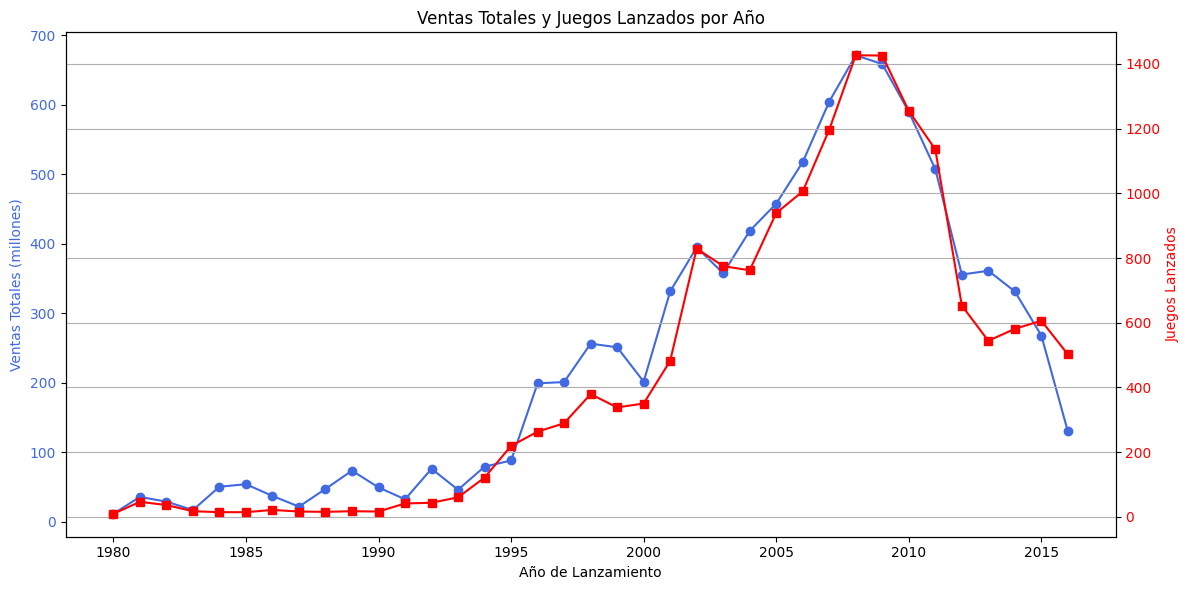

In [ ]:
# Plot relationship between total sales and games released

fig, ax1 = plt.subplots(figsize=(12, 6))

# Axis 1: Total sales
ax1.set_xlabel("Release Year")
ax1.set_ylabel("Total Sales (millions)", color="royalblue")
ax1.plot(launchings_per_year.index, launchings_per_year["total_sales_year"], marker='o', color="royalblue", label="Total Sales")
ax1.tick_params(axis='y', labelcolor="royalblue")

# Axis 2: Games released
ax2 = ax1.twinx()
ax2.set_ylabel("Games Released", color="red")
ax2.plot(launchings_per_year.index, launchings_per_year["games_released"], marker='s', color="red", label="Games Released")
ax2.tick_params(axis='y', labelcolor="red")

# Title and style
plt.title("Total Sales and Games Released by Year")
fig.tight_layout()
plt.grid(True)


In [ ]:
# Year with most sales
year_w_most_sales = launchings_per_year["total_sales_year"].idxmax()
sales_max = launchings_per_year["total_sales_year"].max()

# Year with most releases
year_w_most_games = launchings_per_year["games_released"].idxmax()
launchings_max = launchings_per_year["games_released"].max()

# Show results
print(f"Year with most sales: {year_w_most_sales} ({sales_max:.2f} million)")
print(f"Year with most games released: {year_w_most_games} ({launchings_max} games)")


Año con más ventas: 2008 (671.50 millones)
Año con más juegos lanzados: 2008 (1427 juegos)


**Analysis of sales by year**
1. It can be seen how at the beginning there were few titles and they sold very well, as time goes by, that relationship becomes tighter.
2. The appearance of new consoles makes the volume of video games released and therefore sales magnify.
3. The highest peak, both in sales and games released, is reached in 2008, after that year there is a drop in both, except for 2013, where sales exceed games released.
4. In general, sales are related to the release of video games, the more games are released, the more is sold.

### Sales by genre over the years

In [ ]:
# Count how many games there were per year and per genre
games_by_year_and_genre = df_games.groupby(["year_of_release", "genre"]).size().unstack(fill_value=0)

# View the first years
print(games_by_year_and_genre.head())


genre            Action  Adventure  Fighting  Misc  Platform  Puzzle  Racing  \
year_of_release                                                                
1980                  1          0         1     4         0       0       0   
1981                 25          0         0     0         3       2       1   
1982                 18          0         0     1         5       3       2   
1983                  7          1         0     1         5       1       0   
1984                  1          0         0     1         1       3       3   

genre            Role-Playing  Shooter  Simulation  Sports  Strategy  
year_of_release                                                       
1980                        0        2           0       1         0  
1981                        0       10           1       4         0  
1982                        0        5           0       2         0  
1983                        0        1           0       1         0  
1984         

In [ ]:
# Sum total sales per year and per genre
ventas_por_anio_y_genero = df_games.groupby(["year_of_release", "genre"])["total_sales"].sum().unstack(fill_value=0)

# View the first years
print(ventas_por_anio_y_genero.head())


genre            Action  Adventure  Fighting  Misc  Platform  Puzzle  Racing  \
year_of_release                                                                
1980               0.34        0.0      0.77  2.70      0.00    0.00    0.00   
1981              14.79        0.0      0.00  0.00      6.92    2.25    0.48   
1982               6.50        0.0      0.00  0.87      5.03   10.04    1.57   
1983               2.86        0.4      0.00  2.14      6.93    0.78    0.00   
1984               1.85        0.0      0.00  1.45      0.69    3.14    5.95   

genre            Role-Playing  Shooter  Simulation  Sports  Strategy  
year_of_release                                                       
1980                      0.0     7.07        0.00    0.50       0.0  
1981                      0.0    10.02        0.44    0.78       0.0  
1982                      0.0     3.81        0.00    1.06       0.0  
1983                      0.0     0.49        0.00    3.20       0.0  
1984         

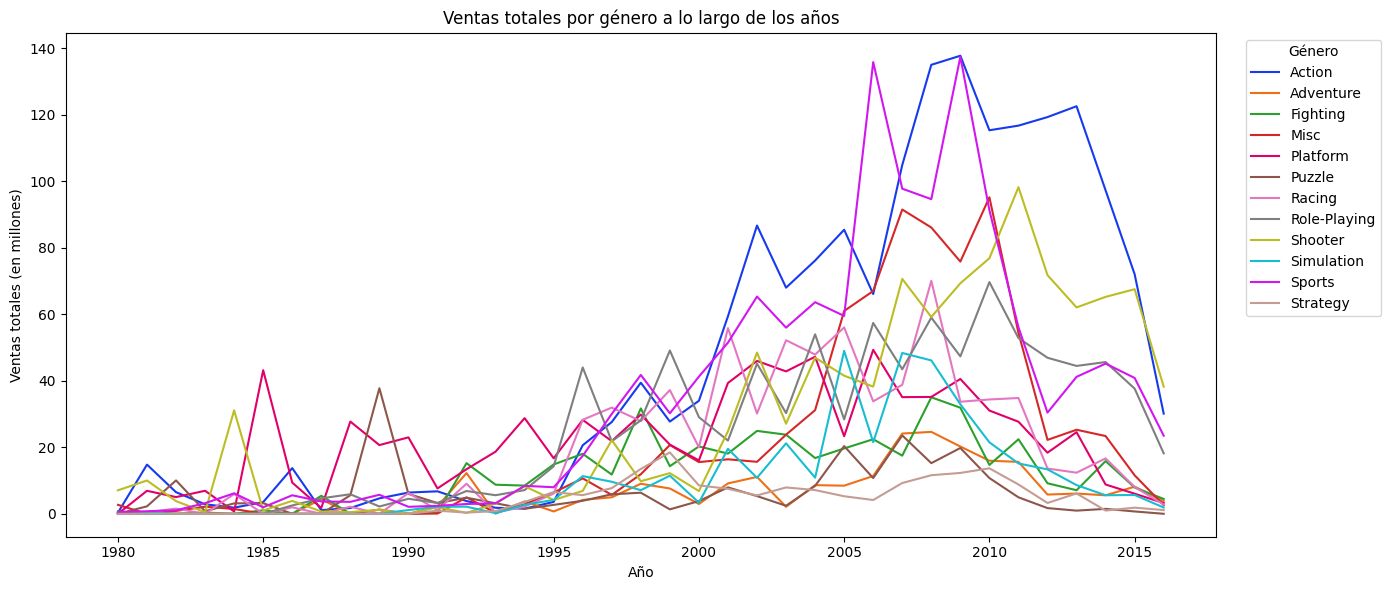

In [ ]:
genre_colors = {
    "Action": "#163af0",     
    "Adventure": "#f06f16",   
    "Fighting": "#2ca02c",    
    "Misc": "#d62728",        
    "Platform": "#e1006a",    
    "Puzzle": "#8c564b",     
    "Racing": "#e377c2",      
    "Role-Playing": "#7f7f7f",
    "Shooter": "#bcbd22",     
    "Simulation": "#17becf",  
    "Sports": "#d216f0",      
    "Strategy": "#c49c94"     
}


# Plot with custom colors by genre
sales_by_year_and_genre.plot(
    figsize=(14, 6),
    color=[genre_colors.get(genre, "black") for genre in sales_by_year_and_genre.columns]
)

plt.title("Total sales by genre over the years")
plt.xlabel("Year")
plt.ylabel("Total sales (in millions)")
plt.legend(title="Genre", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



**Analysis of sales by genre over the years**
1. Initially there were not so many genres, however, pioneering genres like platform or puzzle, instead of gaining strength, lost it.
2. In '95 action begins to rise, as well as sports, both reach the peak of 2005-2010.
3. Misc and shooter genres also enjoy a rise since 2005.
4. Although technology allows improvements in the simulation genre, it does not rise in recent years.
5. The most popular genres are sports and action, with the latter being a great dominant in the contemporary market along with shooter. So we can see that new generations prefer action, shooter and sports genres over strategy or platform, which was very popular at the beginning of the video game era.

## Analysis of games by platforms

### Sales by platform over the years

In [ ]:
# Calculate total sales per platform
sales_by_platform = df_games.groupby("platform")["total_sales"].sum().sort_values(ascending=False)

# Show results
print(sales_by_platform)

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64


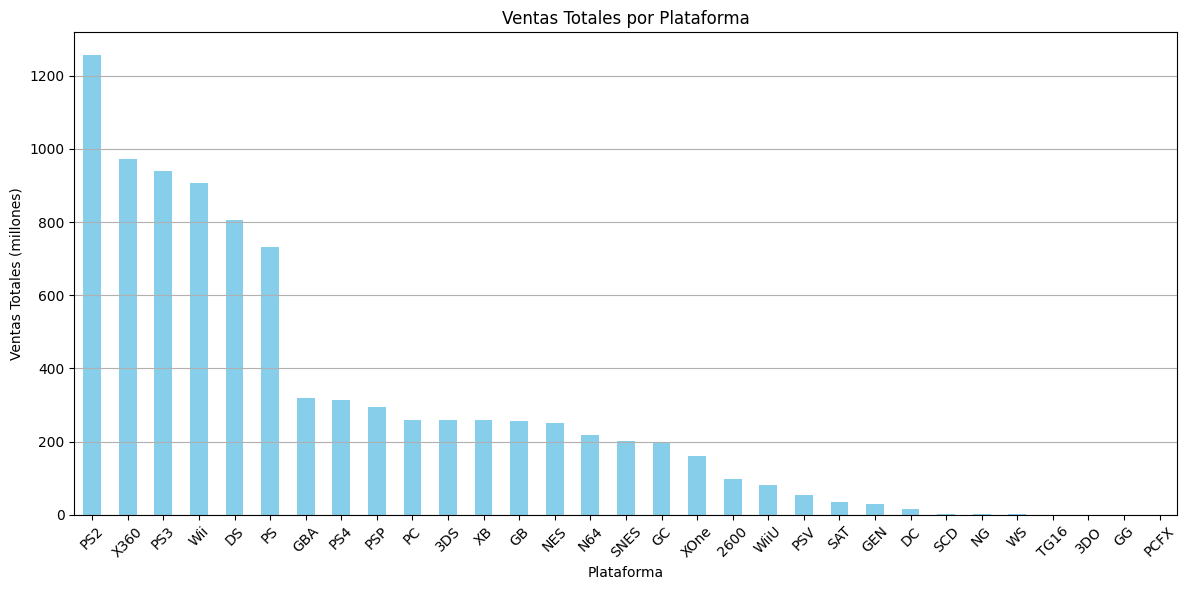

In [ ]:
# Create bar chart for visualization of sales by platform
plt.figure(figsize=(12, 6))
sales_by_platform.plot(kind="bar", color="skyblue")
plt.title("Total Sales by Platform")
plt.xlabel("Platform")
plt.ylabel("Total Sales (millions)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


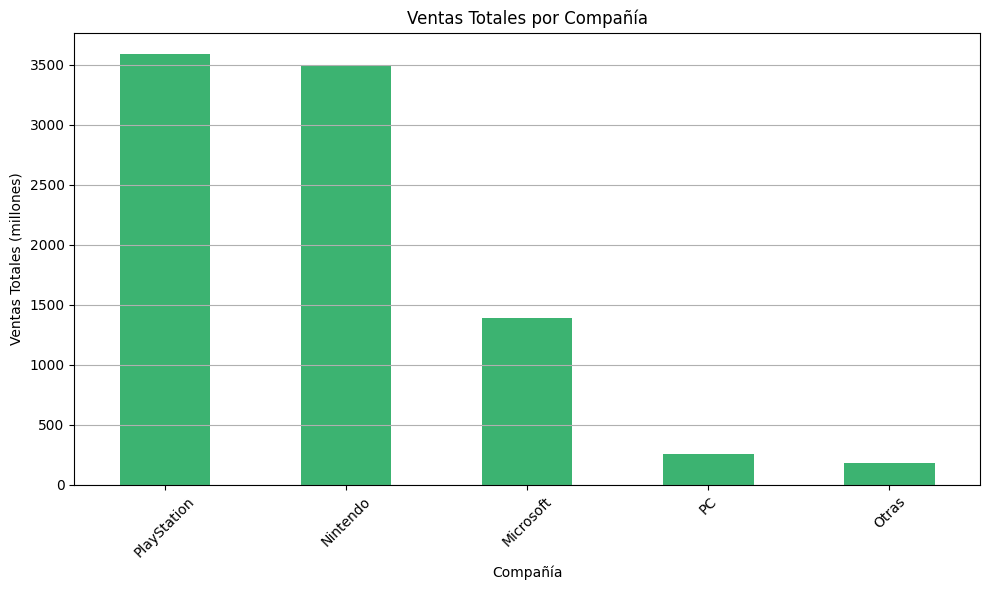

In [ ]:
# Chart for analysis by company
# Create the platform to company mapping
platform_to_company = {
    # Nintendo
    'Wii': 'Nintendo', 'NES': 'Nintendo', 'GB': 'Nintendo', 'DS': 'Nintendo',
    'SNES': 'Nintendo', 'GBA': 'Nintendo', '3DS': 'Nintendo', 'N64': 'Nintendo',
    'WiiU': 'Nintendo', 'GC': 'Nintendo', 
    # PlayStation
    'PS': 'PlayStation', 'PS2': 'PlayStation', 'PS3': 'PlayStation', 
    'PS4': 'PlayStation', 'PSP': 'PlayStation', 'PSV': 'PlayStation',
    # Microsoft (Xbox)
    'X360': 'Microsoft', 'XOne': 'Microsoft', 'XB': 'Microsoft',
    # PC
    'PC': 'PC', 'PC': 'PC'
}

# Apply the mapping
df_games["company"] = df_games["platform"].map(platform_to_company).fillna("Other")

# Group sales by company
sales_by_company = df_games.groupby("company")["total_sales"].sum().sort_values(ascending=False)

# Plot the result
plt.figure(figsize=(10, 6))
sales_by_company.plot(kind="bar", color="mediumseagreen")
plt.title("Total Sales by Company")
plt.xlabel("Company")
plt.ylabel("Total Sales (millions)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

**Brief analysis of platforms**
Our data allows us to see sales of 31 platforms over a period of 34 years. 
1. PlayStation has positioned itself as the leader in game sales, not only the PS2 as the best-selling console, but in general by adding the sales of all its consoles.
2. Nintendo is the company that has been in the market the longest, however, it falls behind PlayStation as the sales leader, the difference is not large, but it shows that buyers prefer games for PlayStation, it could be due to several factors, such as graphics and genres.
3. The difference between Microsoft with Nintendo and PlayStation is quite large, as it does not even reach half of total sales. This clearly shows the preference for certain consoles by players and is a good indicator for launching a new game, as if it is launched for PlayStation and/or Nintendo, it has a higher probability of acceptance, and therefore success. 

### Filtering platforms with most sales

**To perform a better analysis, we will look closely only at platforms that achieved more than 100M in sales. This will help us choose a period as well as platforms that help us better make decisions for 2017**

In [ ]:
# Group by year and platform, summing sales
sales_platform_year = df_games.groupby(["year_of_release", "platform"])["total_sales"].sum().unstack(fill_value=0)

# Show the first rows
print(sales_platform_year.head())
# Sum total sales per platform
total_sales_by_platform = df_games.groupby("platform")["total_sales"].sum()
print()
# Filter platforms with more than 100 million (100.0 in millions)
top_platforms = total_sales_by_platform[total_sales_by_platform > 100].index

# Show selected platforms
print(top_platforms)


platform          2600  3DO  3DS   DC   DS   GB  GBA   GC  GEN   GG  ...  SAT  \
year_of_release                                                      ...        
1980             11.38  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1981             35.68  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1982             28.88  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1983              5.84  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1984              0.27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

platform         SCD  SNES  TG16   WS  Wii  WiiU  X360   XB  XOne  
year_of_release                                                    
1980             0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  
1981             0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  
1982             0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  
1983             0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  
1984             0.0   0

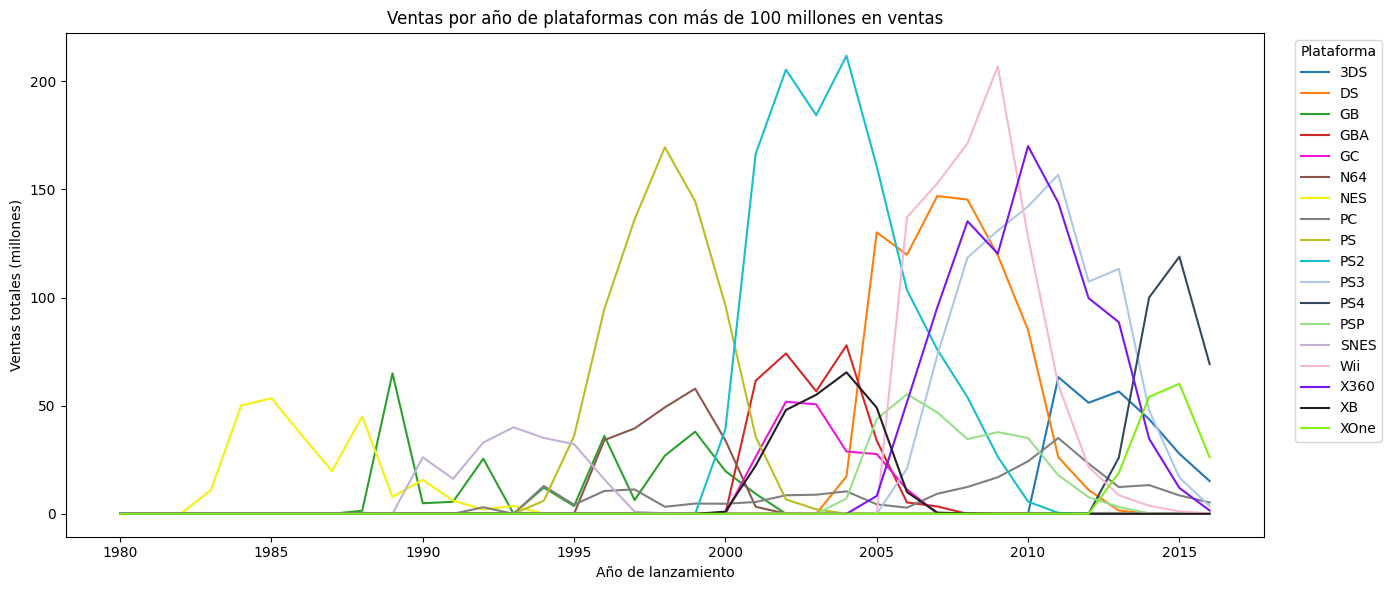

In [ ]:
# Create the table with sales per year and platform
sales_platform_year = df_games.groupby(["year_of_release", "platform"])["total_sales"].sum().unstack(fill_value=0)

# Filter columns (platforms) that are in the top
sales_platform_year_top = sales_platform_year[top_platforms]
# 1. Define the custom colors dictionary
color_custom = {
    "3DS": "#1f77b4",  
    "DS": "#ff7f0e",    
    "GB": "#2ca02c",    
    "GBA": "#d62728",   
    "GC": "#f016d6",    
    "N64": "#8c564b",   
    "NES": "#f7f00c",   
    "PC": "#7f7f7f",    
    "PS": "#bcbd22",    
    "PS2": "#17becf",   
    "PS3": "#aec7e8",   
    "PS4": "#34495e",   
    "PSP": "#98df8a",   
    "SNES": "#c5b0d5", 
    "Wii": "#f7b6d2",   
    "X360": "#7c16f0",  
    "XB": "#241d25",    
    "XOne": "#80f016",  
}

# 2. Filter the table only to desired platforms
top_platforms = list(color_custom.keys())
sales_platform_year_top = sales_platform_year[top_platforms]

# 3. Plot with custom colors
sales_platform_year_top.plot(
    figsize=(14, 6),
    color=[color_custom[platform] for platform in sales_platform_year_top.columns]
)

plt.title("Sales per year of platforms with more than 100 million in sales")
plt.xlabel("Release year")
plt.ylabel("Total sales (millions)")
plt.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()





In [ ]:
# Ensure we use only top platforms
top_platforms = list(color_custom.keys())
df_top_platforms = df_games[df_games["platform"].isin(top_platforms)]

# Step 1: Group by platform and genre → get the best-selling genre
sales_platform_genre = df_top_platforms.groupby(["platform", "genre"])["total_sales"].sum()
best_selling_genre_by_platform = sales_platform_genre.groupby(level=0).idxmax()
highest_sales = sales_platform_genre.groupby(level=0).max()

# Step 2: Get start year and end year of activity per platform
activity_years = df_top_platforms.groupby("platform")["year_of_release"].agg(
    start_year="min",
    end_year="max"
)

# Step 3: Combine everything into a single table
summary = pd.DataFrame({
    "platform": [p for p, _ in best_selling_genre_by_platform],
    "best_selling_genre": [g for _, g in best_selling_genre_by_platform],
    "sales_millions": highest_sales.values,
    "start_year": [activity_years.loc[p, "start_year"] for p, _ in best_selling_genre_by_platform],
    "end_year": [activity_years.loc[p, "end_year"] for p, _ in best_selling_genre_by_platform]
}).sort_values(by="sales_millions", ascending=False)
summary["duration_years"] = summary["end_year"] - summary["start_year"]

# Sort by start year and reset index
summary = summary.sort_values(by="start_year")
summary = summary.reset_index(drop=True)

# Show the final table
print(summary)



   plataforma genero_mas_vendido  ventas_millones  año_inicio  año_final  \
0         NES           Platform            95.78        1983       1994   
1          PC         Simulation            52.51        1985       2016   
2          DS               Misc           135.64        1985       2013   
3          GB       Role-Playing            88.24        1988       2001   
4        SNES           Platform            65.65        1990       1999   
5          PS             Action           127.02        1994       2003   
6         N64             Racing            40.01        1996       2002   
7          XB            Shooter            63.54        2000       2008   
8         PS2             Sports           273.48        2000       2011   
9         GBA           Platform            78.21        2000       2007   
10         GC             Action            37.70        2001       2007   
11        PSP             Action            64.03        2004       2015   
12       X36

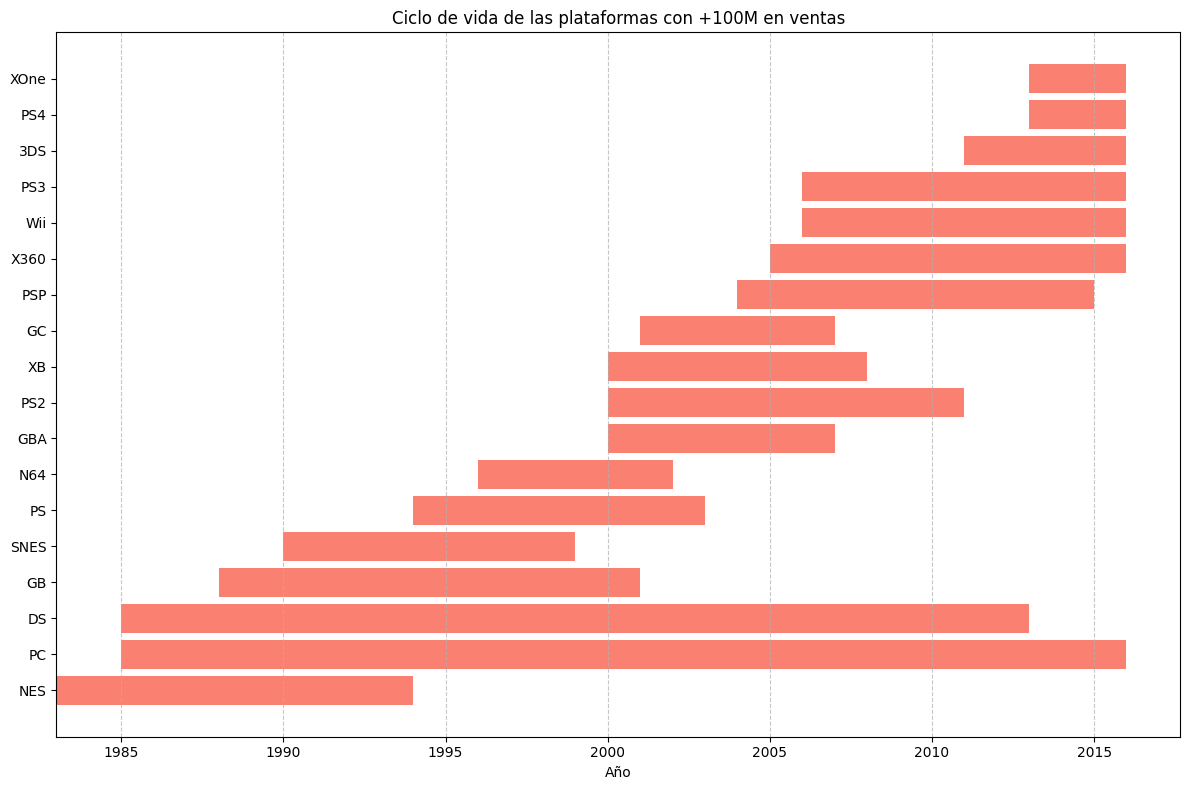

In [ ]:
# Sort by start year for better visualization
summary = summary.sort_values(by="start_year")

# Create horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(
    summary["platform"],
    summary["end_year"] - summary["start_year"],
    left=summary["start_year"],
    color="salmon"
)

# Titles and labels
plt.xlabel("Year")
plt.title("Lifecycle of platforms with +100M in sales")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Analysis of platform sales**
1. In the 80s when video game sales began, there were few platforms in the market and it can be seen how as one's sales decline, a new one emerges that surpasses it, as the NES was leading, but in its decline the GB is launched raising sales.
2. In the graph it can be seen how the year when more platforms begin to appear is from 2000, where not only Nintendo and PlayStation dominate the market, but a new competitor enters: Microsoft's Xbox.
3. The PS2 reaches its peak sales in 2004, however, its decline is slow, as it remains in the market until 2011.
4. At first glance it can be seen that the lifespan of platforms is 5 years, with exceptions in the PS2, Wii and X360. In these cases, an approach can be made to analyze what these platforms have done to remain longer in the market, as their sales process follows a normal distribution, showing a learning process by each developer, where innovation has undoubtedly been key to their success.
5. The PC is the platform that has remained in the market the longest, however, its sales have never been outstanding. The year with the most sales was 2011, when the most successful platforms were already in decline in the market.
6. Although portable platforms showed innovation, none have sold like the most innovative platforms (Wii, PS2, X360). The most successful portable platform was the DS, reaching almost 150M in 2006, the GB is the one that has remained in the market the longest, with about 13 years in the market. Although PlayStation dominates the platform market, in the case of portables that same success was not seen, in that case Nintendo is the sales leader.

## Data segmentation for analysis

**Determine what data to use for building a model for 2017**
Based on the data, I have decided to use two filters: 
1. Years: 2005-2016
2. Platforms: Those with more than 200M in sales.
   This gives enough time to analyze rise and fall in sales, taking into account the lifespan of platforms. Although there are many platforms, it is ideal to use more concrete data, by filtering them by more than 200M it allows us to closely analyze those that were (or still are) leaders, not only by name but by innovation and strategy. Although the PS2 has been the best-selling console, in this analysis it will still be present, but as a platform in decline, in this period of years we will be able to analyze the rise and fall of the Wii.

### Data preparation for analysis

In [ ]:
# Filter DataFrame by year range
df_period = df_games[(df_games["year_of_release"] >= 2005) & (df_games["year_of_release"] <= 2016)]

# Group by platform and sum sales in that period
sales_period = df_period.groupby("platform")["total_sales"].sum()

# Filter platforms with more than 200 million in sales
platforms_200m = sales_period[sales_period > 200].sort_values(ascending=False)

# Show results
print(platforms_200m)


platform
X360    961.24
PS3     931.34
Wii     891.18
DS      785.49
PS2     426.46
PS4     314.14
PSP     282.47
3DS     257.81
Name: total_sales, dtype: float64


### Statistical analysis

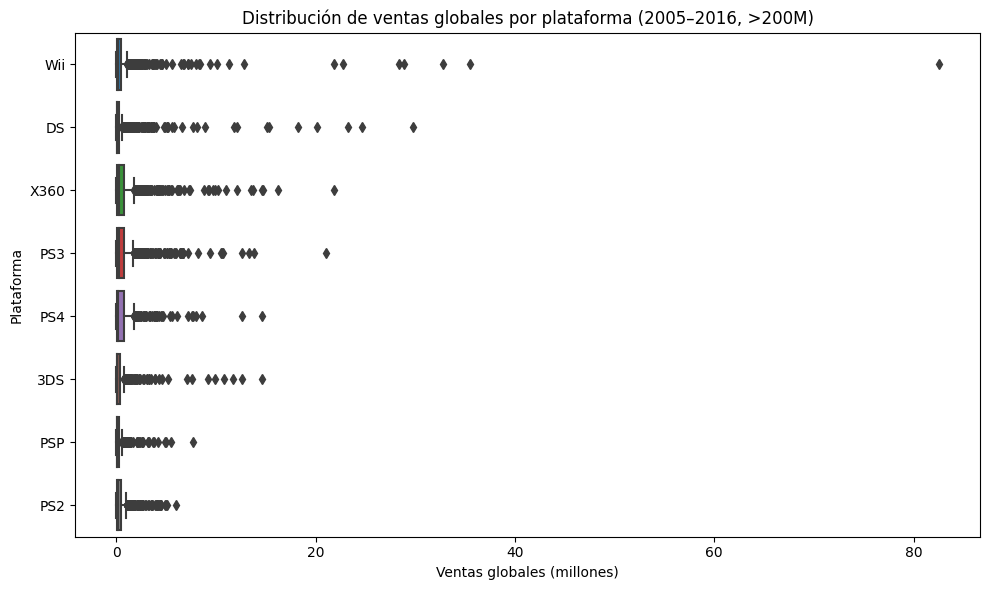

In [ ]:
# Box plot for sales by platform  
# Step 1: Filter data between 2005 and 2016
df_period = df_games[(df_games["year_of_release"] >= 2005) & (df_games["year_of_release"] <= 2016)]

# Step 2: Get platforms with more than 200 million in sales in that period
sales_period = df_period.groupby("platform")["total_sales"].sum()
platforms_200m = sales_period[sales_period > 200].index

# Step 3: Filter DataFrame only with those platforms
df_top200 = df_period[df_period["platform"].isin(platforms_200m)]

# Step 4: Create horizontal boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top200, y="platform", x="total_sales", orient="h")

plt.title("Distribution of global sales by platform (2005–2016, >200M)")
plt.ylabel("Platform")
plt.xlabel("Global sales (millions)")
plt.tight_layout()



**Box plot data by platform**
1. There are many outliers especially in Wii, DS and PS2, where some titles reached extremely high sales. This tells us that their "star" games generated many sales.
2. The median sales are usually located near 0 for most platforms, which indicates that most games have modest sales, but a few big hits push the total upward.
3. Dispersion (interquartile range) varies by platform. For example:
Wii and DS have greater dispersion, indicating that on these consoles there were very successful titles but also many with low sales.
4. PS4 and X360 show a more contained distribution, as they are next-generation platforms, we still don't see their decline.
5. Taking into account the great success of the PS2, we can see that the PS3 continues with good sales margins, achieving balanced sales, although it doesn't have as many "star" games as the Wii, it is positioned as a "stable" platform in terms of user acceptance in game purchases.
6. In portable consoles, the DS is very well positioned, far surpassing its competitor the PSP in terms of "star" game success.

In [ ]:
# Add standard deviation and variance
extra_statistics = df_top200.groupby("platform")["total_sales"].agg(
    Q1=lambda x: x.quantile(0.25),
    Median=lambda x: x.median(),
    Q3=lambda x: x.quantile(0.75),
    Min="min",
    Max="max",
    Std_Dev="std",
    Variance="var"
)

# Show the table
print(extra_statistics)


            Q1  Mediana      Q3   Min    Max  Desviacion   Varianza
platform                                                           
3DS       0.05     0.12  0.3325  0.01  14.60    1.441271   2.077262
DS        0.05     0.11  0.2700  0.01  29.80    1.427025   2.036401
PS2       0.05     0.16  0.4300  0.00   5.95    0.707855   0.501059
PS3       0.11     0.28  0.7600  0.00  21.05    1.403065   1.968590
PS4       0.06     0.20  0.7300  0.01  14.63    1.609456   2.590350
PSP       0.03     0.09  0.2300  0.01   7.68    0.520723   0.271152
Wii       0.09     0.19  0.4875  0.01  82.54    3.165022  10.017362
X360      0.11     0.28  0.7700  0.01  21.82    1.632122   2.663823


**Analysis of descriptive statistics**
1. Platforms like Wii and DS stand out for their high variances and standard deviations, which confirms that they have very heterogeneous sales.
2. PS4 and PS3 show lower variance, indicating that most of their games had more stable performance.
Variance and standard deviation allow us to understand the risk or instability in sales of each platform.
For example:
Wii: extremely variable sales (many bestsellers and many failures).
PS4: more uniform sales among titles.

In [ ]:
# Create sales matrix per game, where each column is a platform
# We use only games from period 2005–2016 and platforms > 200M
sales_matrix = df_top200.pivot_table(
    index="name", 
    columns="platform", 
    values="total_sales", 
    aggfunc="sum",
    fill_value=0
)

# Calculate covariance matrix
covariance = sales_matrix.cov()

# Show
print("\nCovariance matrix:")
print(covariance)



Matriz de covarianza:
platform       3DS        DS       PS2       PS3       PS4       PSP  \
platform                                                               
3DS       0.181096 -0.004043 -0.002497 -0.002163 -0.000809 -0.001517   
DS       -0.004043  0.685056 -0.000725 -0.005523 -0.005705 -0.000230   
PS2      -0.002497 -0.000725  0.103651  0.010961 -0.003148  0.013785   
PS3      -0.002163 -0.005523  0.010961  0.475352  0.085321  0.006852   
PS4      -0.000809 -0.005705 -0.003148  0.085321  0.191574 -0.001872   
PSP      -0.001517 -0.000230  0.013785  0.006852 -0.001872  0.057444   
Wii      -0.000187  0.010995  0.007490  0.012301 -0.005273 -0.000652   
X360     -0.002676 -0.002162  0.016699  0.373097  0.069175  0.003596   

platform       Wii      X360  
platform                      
3DS      -0.000187 -0.002676  
DS        0.010995 -0.002162  
PS2       0.007490  0.016699  
PS3       0.012301  0.373097  
PS4      -0.005273  0.069175  
PSP      -0.000652  0.003596  
Wii     

To complement the statistical data from the previous step, I decided to calculate the covariance as well as the relationship between them and discover more interesting findings in our analysis. I plot the result below in a heatmap to better appreciate its data and interpretation.

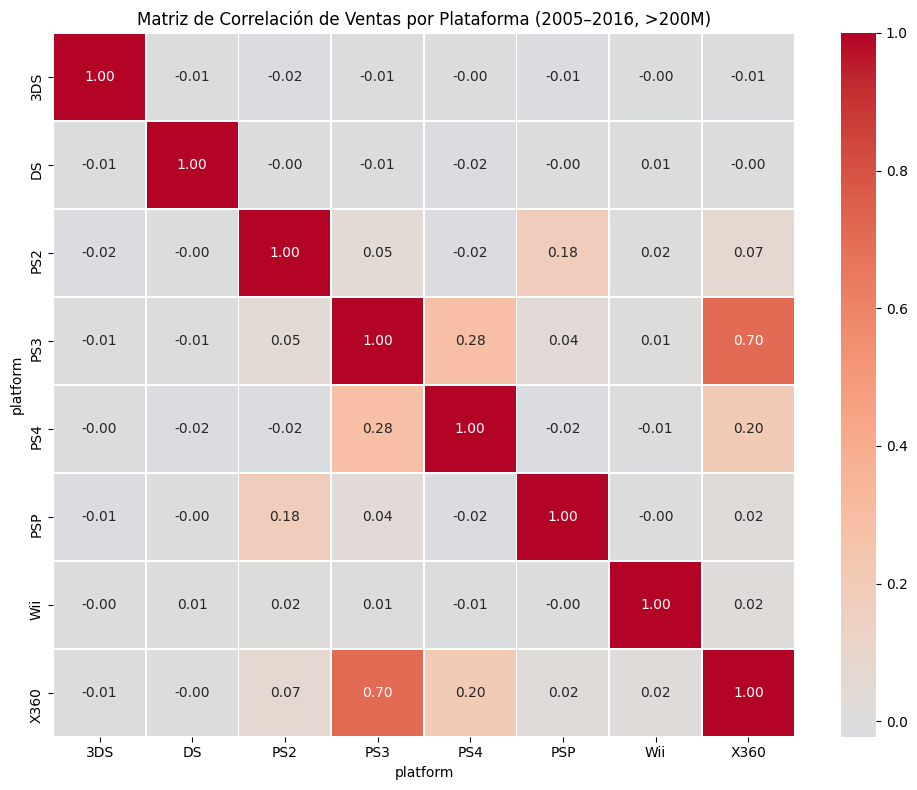

In [ ]:
# Calculate correlation matrix
correlation = sales_matrix.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Sales by Platform (2005–2016, >200M)")
plt.tight_layout()

**Key findings from correlation matrix**
1. PS3-X360: High correlation: many successful games were released on both platforms.
2. PS3-PS4: Moderate relationship: the transition between generations was gradual.
3. PS2-PSP: Low positive correlation, both from Sony, but different catalogs.
4. PS4-X360: Moderate correlation. The PS4 arrives when the X360 is already in decline, however, it showed a bit at the beginning.
5. 3DS - DS: Very close to 0: although both are Nintendo portables, they don't show directly related sales in the same period.
6. Nintendo consoles: Although in our platform filter there are 3 Nintendo platforms, they have very little correlation, it could be due to the difference in game variety.
7. Nintendo DS/Wii with others: Very low or null correlation with other platforms, suggesting different catalogs and audiences.

**Final comment on statistical analysis of "top" platforms**
1. The differences in sales between platforms are significant.
2. The market is clearly dominated by a few bestsellers ("star" games) per platform.
3. Each company shows a different sales dispersion profile:
Nintendo dominates in terms of high dispersions (big bestsellers).
PlayStation tends to have a more balanced catalog.
Microsoft usually has lower dispersion, but good constant volumes.
4. Covariance suggests that sales successes are not always shared between rival platforms.
5. Video games launched for PlayStation and/or Microsoft can generate more stable sales. Launching games for Nintendo will depend on more factors for their success, however, they can be more successful than on the others. 

### Relationship between critic and user scores vs sales (Wii)

The purpose of this analysis is to determine how much critic scores affect sales. Not all games that go on sale have this metric, however, it is an important factor to analyze, for this, I have selected the Wii platform.

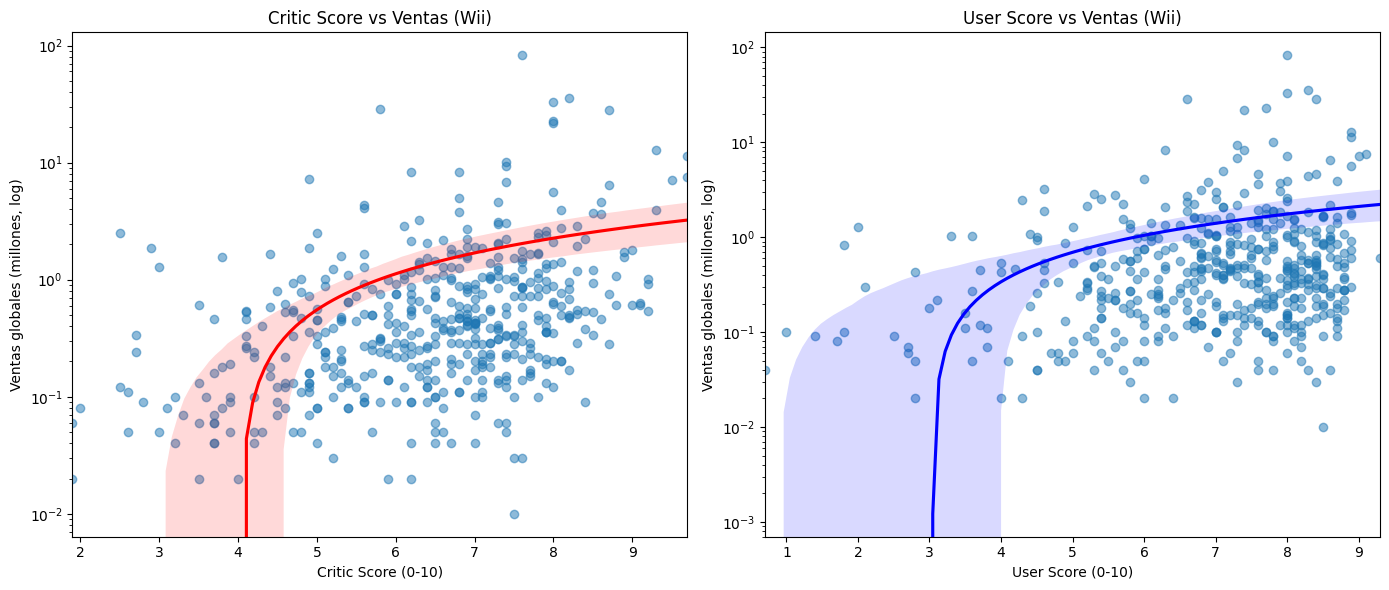

In [ ]:
# Improved chart of review correlation and sales (Wii)

# Filter Wii again with complete data
df_wii = df_games[
    (df_games["platform"] == "Wii") &
    (df_games["user_score"].notna()) &
    (df_games["critic_score"].notna()) &
    (df_games["total_sales"].notna())
]

plt.figure(figsize=(14, 6))

# Subplot 1: Critic Score
plt.subplot(1, 2, 1)
sns.regplot(
    data=df_wii, 
    x="critic_score", 
    y="total_sales", 
    scatter_kws={'alpha':0.5}, 
    line_kws={'color':'red'}
)
plt.yscale('log')
plt.title("Critic Score vs Sales (Wii)")
plt.xlabel("Critic Score (0-10)")
plt.ylabel("Global sales (millions, log)")

# Subplot 2: User Score
plt.subplot(1, 2, 2)
sns.regplot(
    data=df_wii, 
    x="user_score", 
    y="total_sales", 
    scatter_kws={'alpha':0.5}, 
    line_kws={'color':'blue'}
)
plt.yscale('log')
plt.title("User Score vs Sales (Wii)")
plt.xlabel("User Score (0-10)")
plt.ylabel("Global sales (millions, log)")

plt.tight_layout()
plt.show()


In [ ]:
# Pearson correlation calculation:

# Correlation between Critic Score and Sales
correlacion_critic = df_wii["critic_score"].corr(df_wii["total_sales"])

# Correlation between User Score and Sales
correlacion_user = df_wii["user_score"].corr(df_wii["total_sales"])

# Print results
print(f"Correlation Critic Score vs Sales: {correlacion_critic:.3f}")
print(f"Correlation User Score vs Sales: {correlacion_user:.3f}")


Correlación Puntaje de la crítica vs Ventas: 0.170
Correlación Puntaje del usuario vs Ventas: 0.110


**Conclusion on relationship between critic and user scores with Wii sales**
1. Reviews (especially from critics) have a slight positive influence on global sales, however, they do not guarantee commercial success, as there are many more factors, such as marketing, graphics, preferences and/or genre.
2. To have a more accurate number, Pearson's scale was used and we can see the following results:
   Critic Score shows a somewhat higher correlation (+0.17), which indicates that better reviews tend to have a slight increase in sales.
   User Score has an even lower relationship (+0.11), so user preference has little direct influence on sales volume.

### Comparison of Wii games with other platforms

In [ ]:
# Get Wii games that are on multiple platforms
# Filter games on top platforms
df_top_platforms = df_games[df_games["platform"].isin(platforms_200m)]

# Filter games that were released on Wii
wii_games = df_top_platforms[df_top_platforms["platform"] == "Wii"]["name"].unique()

# Filter games that are on at least 2 platforms in the group and one is Wii
multiplatform_games_with_wii = df_top_platforms[df_top_platforms["name"].isin(wii_games)]

# Group by name and count on how many platforms it was
platform_count = multiplatform_games_with_wii.groupby("name")["platform"].nunique()

# Filter those that appear on more than 1 platform (i.e., Wii + at least one more)
games_with_others = platform_count[platform_count > 1]

# Show some results
print(games_with_others.sort_values(ascending=False).head(10))



name
FIFA Soccer 11                6
Wall-E                        6
The Simpsons Game             6
WWE SmackDown vs. Raw 2009    6
FIFA 12                       6
FIFA 14                       6
WWE SmackDown vs Raw 2008     6
FIFA Soccer 08                6
Major League Baseball 2K11    6
Major League Baseball 2K10    6
Name: platform, dtype: int64


In [ ]:
# Create comparative table of 10 titles removing duplicate titles
# Select the 10 most multiplatform games
top_10_games = games_with_others.head(10).index.tolist()

# Create comparative sales table per game and platform
comparative_sales_table = df_top_platforms[df_top_platforms["name"].isin(top_10_games)]

# Get the genre of each game (using only one row per name to avoid duplicates)
genres = (
    comparative_sales_table
    .drop_duplicates(subset=["name"])
    .set_index("name")["genre"]
)

# Create pivot table and add genre
sales_table = comparative_sales_table.pivot_table(
    index="name", columns="platform", values="total_sales", aggfunc="sum", fill_value=0
)

# Add genre column
sales_table.insert(0, "genre", sales_table.index.map(genres))

# Show final table
print(sales_table)



platform                                 genre    DS   PS2   PS3   PSP   Wii  \
name                                                                           
007: Quantum of Solace                  Action  0.13  0.43  1.15  0.00  0.65   
2010 FIFA World Cup South Africa        Sports  0.00  0.00  1.23  0.46  0.43   
428: Fuusa Sareta Shibuya de         Adventure  0.00  0.00  0.02  0.04  0.13   
AC/DC LIVE: Rock Band Track Pack          Misc  0.00  0.16  0.24  0.00  0.26   
AMF Bowling Pinbusters!                 Sports  0.06  0.00  0.00  0.00  0.91   
ATV Quad Kings                          Racing  0.11  0.00  0.00  0.00  0.21   
Alice in Wonderland                  Adventure  0.46  0.00  0.00  0.00  0.51   
Alien Syndrome                    Role-Playing  0.00  0.00  0.00  0.08  0.05   
Aliens in the Attic                     Action  0.05  0.00  0.00  0.00  0.08   
All Star Cheer Squad                    Sports  0.28  0.00  0.00  0.00  0.80   

platform                          X360 

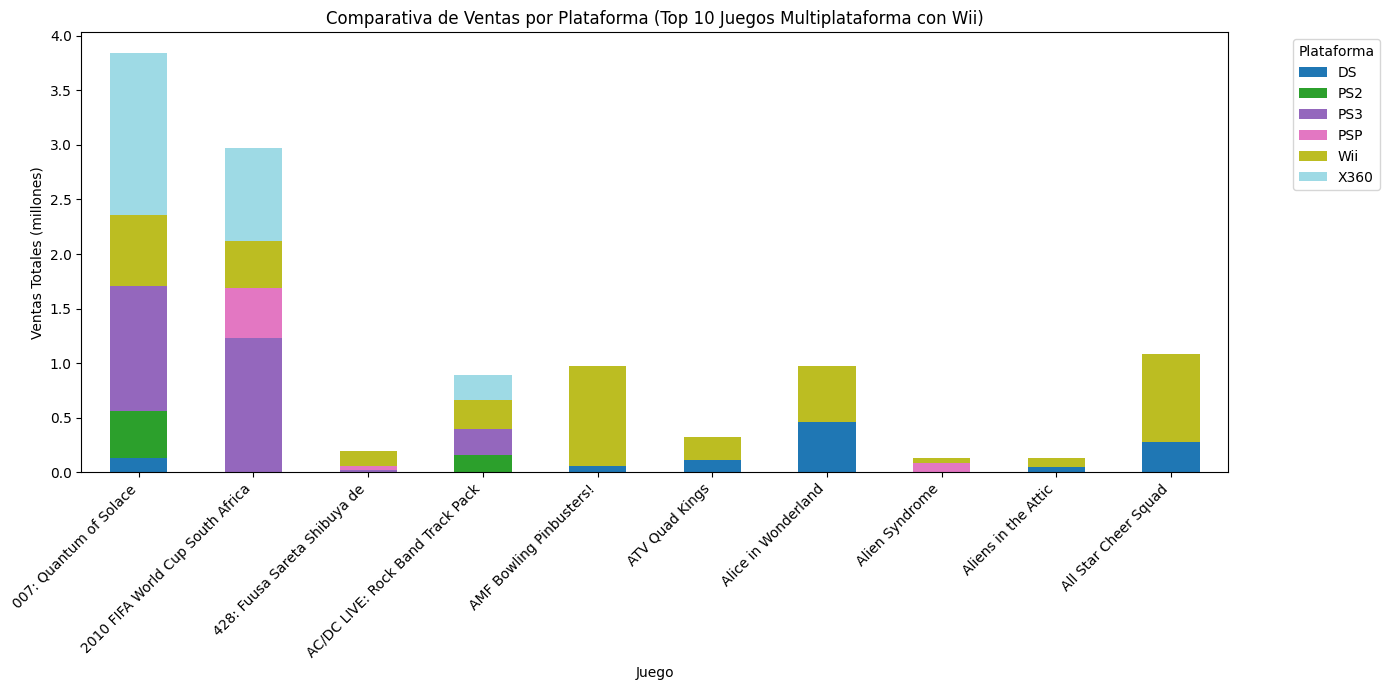

In [ ]:
# Create stacked bar chart
sales_table_no_genre = sales_table.drop("genre", axis=1)

sales_table_no_genre.plot(
    kind="bar", stacked=True, figsize=(14, 7), colormap="tab20"
)

plt.title("Sales Comparison by Platform (Top 10 Multiplatform Games with Wii)")
plt.xlabel("Game")
plt.ylabel("Total Sales (millions)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



**Comment on Wii VS other platforms**
Although the Wii shares titles with other consoles, sales seem to have great variation, as the Wii is not a leader, unless it is with Nintendo platforms, as in the titles "Alice in Wonderland". This helps us see that the Wii's big successes are exclusive titles, as when facing other platforms, it loses strength in sales, and this is due to different factors.

### Information by genre on top platforms

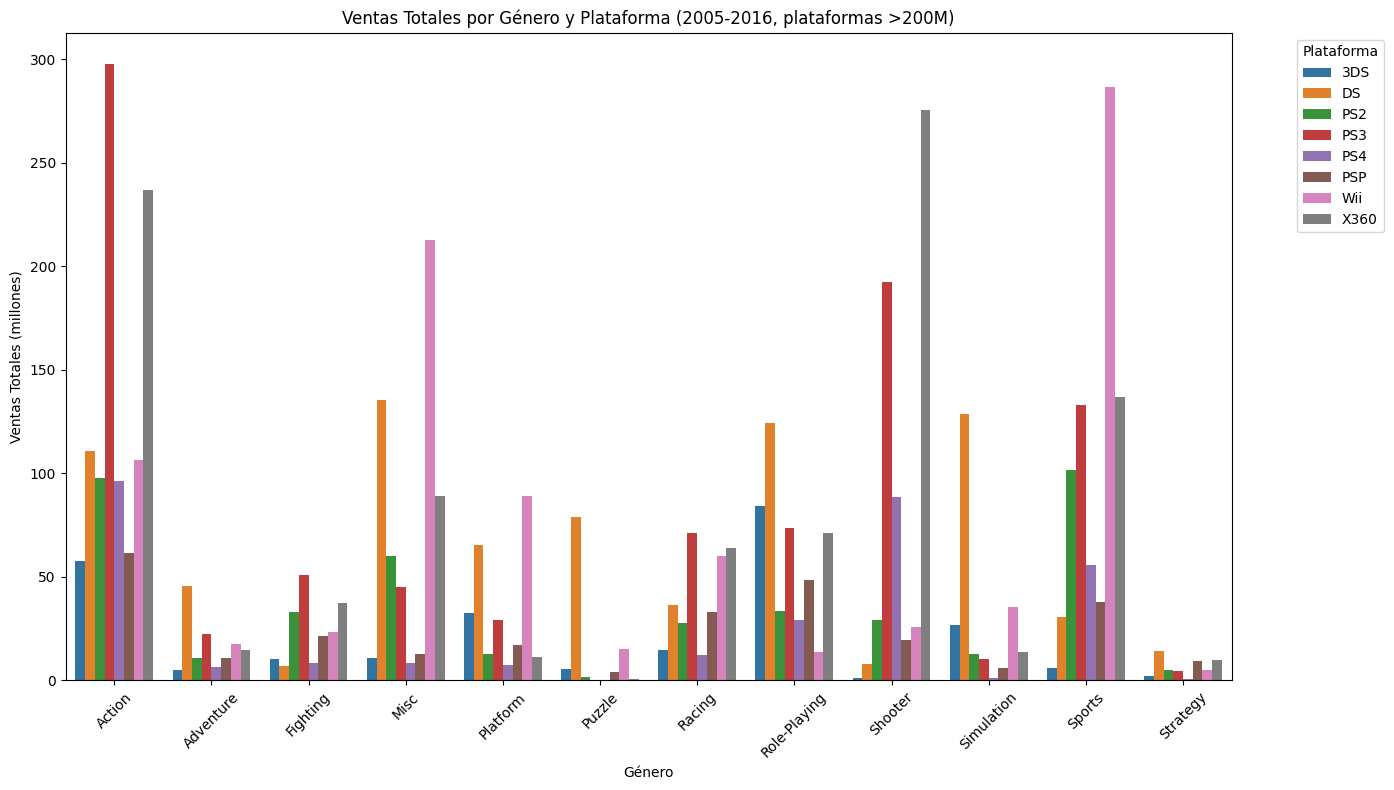

In [ ]:
# Group by platform and genre to sum sales
sales_genre = df_top200.groupby(["platform", "genre"])["total_sales"].sum().reset_index()

# Plot sales by genre and platform
plt.figure(figsize=(14, 8))
sns.barplot(
    data=sales_genre, 
    x="genre", 
    y="total_sales", 
    hue="platform"
)
plt.title("Total Sales by Genre and Platform (2005-2016, platforms >200M)")
plt.xlabel("Genre")
plt.ylabel("Total Sales (millions)")
plt.xticks(rotation=45)
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Comment on the general distribution of games by genre** For this chart we continue to use our filter of the 8 top platforms.
1. What can be said about the most profitable genres? The genres with the best sales are 'Action', 'shooter' and 'Sports'. In each of them, there is a platform that is the leader and that wins by far over the others. We could say that platforms come to be recognized for games of a specific genre and this makes companies also base themselves on this data when choosing which platforms they will be on or the same video game companies allocate their resources to the development of specific genres.
2. Can you generalize about genres with high and low sales? It can be generalized that platforms have greater success, whether due to marketing or graphic and performance aspects. We can say that the most profitable genres sell more on PlayStation and Microsoft consoles, while Nintendo stands out as a leader in sports and Misc. 

## Profile for each region

**In this section we will work and analyze data by region, this will give us a better geographic perspective regarding tastes, interest in certain genres and platform preferences**

### Sales by region

In [ ]:
# PREPARATION: Filter data for period 2005-2016
print(" DATA PREPARATION FOR REGIONAL PROFILE\n")

# Filter data for relevant period 2005-2016
df_period = df_games[
    (df_games["year_of_release"] >= 2005) & 
    (df_games["year_of_release"] <= 2016)
].copy()

print(f" FILTERED DATA:")
print(f"• Complete dataset: {len(df_games):,} games")
print(f"• Period 2005-2016: {len(df_period):,} games ({len(df_period)/len(df_games)*100:.1f}%)")
print(f"• Years analyzed: {int(df_period['year_of_release'].min())} - {int(df_period['year_of_release'].max())}")

# Calculate total sales per region for the period
regional_sales_period = {
    "North America (NA)": df_period["na_sales"].sum(),
    "Europe (EU)": df_period["eu_sales"].sum(), 
    "Japan (JP)": df_period["jp_sales"].sum(),
    "Other regions": df_period["other_sales"].sum()
}

print(f"\n TOTAL SALES BY REGION (2005-2016):")
for region, sales in regional_sales_period.items():
    percentage = (sales / df_period["total_sales"].sum()) * 100
    print(f"{region:<20}: {sales:>8.2f} million ({percentage:5.1f}%)")

world_total_period = sum(regional_sales_period.values())
print(f"\n GLOBAL TOTAL (2005-2016): {world_total_period:8.2f} million")
print(f" This period represents {(world_total_period/df_games['total_sales'].sum())*100:.1f}% of all historical sales")


 PREPARACIÓN DE DATOS PARA PERFIL REGIONA

 DATOS FILTRADOS:
• Dataset completo: 16,713 juegos
• Período 2005-2016: 11,272 juegos (67.4%)
• Años analizados: 2005 - 2016

 VENTAS TOTALES POR REGIÓN (2005-2016):
Norteamérica (NA)   :  2628.82 millones ( 48.2%)
Europa (EU)         :  1617.11 millones ( 29.6%)
Japón (JP)          :   615.58 millones ( 11.3%)
Otras regiones      :   593.33 millones ( 10.9%)

 TOTAL MUNDIAL (2005-2016):  5454.84 millones
 Este período representa el 61.2% de todas las ventas históricas


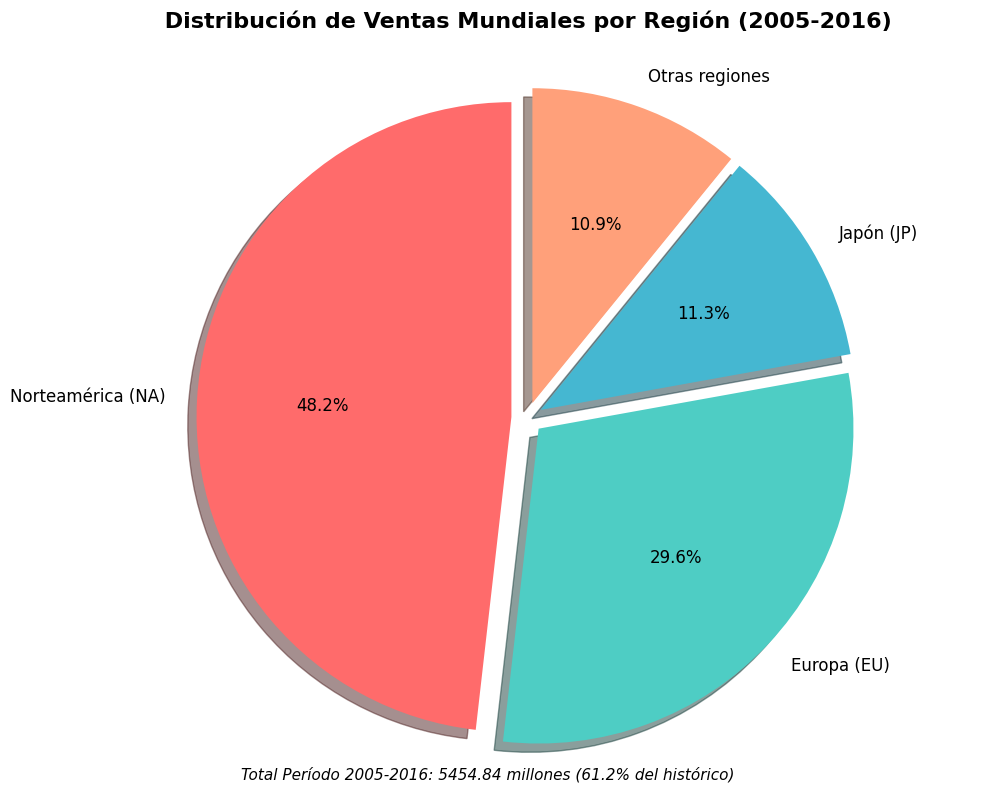

 COMPARACIÓN: PERÍODO 2005-2016 vs HISTÓRICO COMPLETO:
Región               2005-2016 (M)   % Período    Histórico (M)   % Histórico
Norteamérica (NA)          2628.8       48.2%          4400.6       49.4%
Europa (EU)                1617.1       29.6%          2424.1       27.2%
Japón (JP)                  615.6       11.3%          1297.3       14.6%
Otras regiones              593.3       10.9%           791.2        8.9%
 El período 2005-2016 representa 61.2% de todas las ventas históricas


In [ ]:
# Visualization of regional distribution (2005-2016) - Pie chart
# Create pie chart for regional sales of period 2005-2016
plt.figure(figsize=(10, 8))

# Use filtered data from period 2005-2016
# (This variable should have been created previously with year filter)
regions = list(regional_sales_period.keys())
values = list(regional_sales_period.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Create pie chart with better style
plt.pie(values, labels=regions, autopct='%1.1f%%', startangle=90, colors=colors,
        explode=(0.05, 0.05, 0.05, 0.05), shadow=True, textprops={'fontsize': 12})

plt.title(' Global Sales Distribution by Region (2005-2016)', 
          fontsize=16, fontweight='bold', pad=20)

# Add specific information from the period
total_sales_period = sum(values)
percentage_of_total = (total_sales_period / df_games['total_sales'].sum()) * 100

plt.figtext(0.5, 0.02, f'Total Period 2005-2016: {total_sales_period:.2f} million ({percentage_of_total:.1f}% of historical)', 
           ha='center', fontsize=11, style='italic')

plt.axis('equal')  # So the pie is circular
plt.tight_layout()
plt.show()

# Show comparison between period 2005-2016 vs complete historical data
print(f" COMPARISON: PERIOD 2005-2016 vs COMPLETE HISTORICAL:")
print(f"{'Region':<20} {'2005-2016 (M)':<15} {'% Period':<12} {'Historical (M)':<15} {'% Historical'}")
print("="*85)

# Calculate complete historical sales
historical_sales = {
    "North America (NA)": df_games["na_sales"].sum(),
    "Europe (EU)": df_games["eu_sales"].sum(), 
    "Japan (JP)": df_games["jp_sales"].sum(),
    "Other regions": df_games["other_sales"].sum()
}

for region in regions:
    sales_period = regional_sales_period[region]
    sales_hist = historical_sales[region]
    pct_period = (sales_period / total_sales_period) * 100
    pct_hist = (sales_hist / sum(historical_sales.values())) * 100
    
    print(f"{region:<20} {sales_period:>12.1f}   {pct_period:>8.1f}%    {sales_hist:>12.1f}   {pct_hist:>8.1f}%")

print("="*85)
print(f" The period 2005-2016 represents {percentage_of_total:.1f}% of all historical sales")


**Sales chart interpretation**
1. The selected period (2005-2016) represents 61.2% of sales, which tells us that in 11 years more than half of games were sold, taking into account that our data is from a period of 34 years. This indicates a large increase in sales and platform acquisition globally.
2. The sales leader is North America, with almost half of sales. Europe is a region that spans 1 continent, ranks 2nd, but Japan as a country represents an important amount in sales.

### Genres by region

In [ ]:
# ANALYSIS OF MOST POPULAR GENRES BY REGION (2005-2016)
print(" TOP 5 MOST POPULAR GENRES BY REGION (2005-2016):\n")

# Calculate sales by genre and region for filtered period
generos_por_region_periodo = df_periodo.groupby("genre")[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum()

# Top 5 genres by region

for region, columna in [("Norteamérica", "na_sales"), ("Europa", "eu_sales"), ("Japón", "jp_sales"), (" Otras", "other_sales")]:
    top_generos = generos_por_region_periodo[columna].sort_values(ascending=False).head(5)
    total_region = generos_por_region_periodo[columna].sum()
    
    print(f"\n {region} (Total: {total_region:.1f}M):")
    for i, (genero, ventas) in enumerate(top_generos.items(), 1):
        porcentaje = (ventas / total_region) * 100
        print(f"  {i}. {genero:<15}: {ventas:>6.1f}M ({porcentaje:4.1f}%)")






 TOP 5 GÉNEROS MÁS POPULARES POR REGIÓN (2005-2016):


 Norteamérica (Total: 2628.8M):
  1. Action         :  580.0M (22.1%)
  2. Sports         :  432.7M (16.5%)
  3. Shooter        :  401.0M (15.3%)
  4. Misc           :  311.8M (11.9%)
  5. Role-Playing   :  211.9M ( 8.1%)

 Europa (Total: 1617.1M):
  1. Action         :  372.6M (23.0%)
  2. Sports         :  265.6M (16.4%)
  3. Shooter        :  248.1M (15.3%)
  4. Misc           :  167.1M (10.3%)
  5. Racing         :  129.1M ( 8.0%)

 Japón (Total: 615.6M):
  1. Role-Playing   :  179.6M (29.2%)
  2. Action         :  108.4M (17.6%)
  3. Misc           :   72.5M (11.8%)
  4. Sports         :   52.5M ( 8.5%)
  5. Platform       :   36.3M ( 5.9%)

  Otras (Total: 593.3M):
  1. Action         :  141.0M (23.8%)
  2. Sports         :  102.5M (17.3%)
  3. Shooter        :   88.9M (15.0%)
  4. Misc           :   64.4M (10.9%)
  5. Racing         :   44.8M ( 7.6%)


**Analysis of genre preferences among regions**
1. There are 3 genres with the most preference present in all 4 regions: 'Action', 'Shooter' and 'Sports'. This represents that globally, the sales trend leans towards those genres.
2. North America and Europe have very similar preferences, except that in Europe, instead of Role-Playing, they buy more 'Racing'.
3. In Japan we can see a difference, as a region they prefer 'Role-Playing' over 'Action', even in their top 5 shooter is not found.
4. Other regions have the same behavior as Europe.
5. Globally, we could say that the Action genre is one of the most profitable, and almost all regions have similar preferences, except Japan.

### Platform preferences by region

In [ ]:
# ANALYSIS OF MOST SUCCESSFUL PLATFORMS BY REGION (2005-2016)
print(" TOP 5 MOST SUCCESSFUL PLATFORMS BY REGION (2005-2016):\n")

# Calculate sales by platform and region for filtered period
plataformas_por_region_periodo = df_periodo.groupby("platform")[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum()

# Top 5 platforms by region

for region, columna in [("Norteamérica", "na_sales"), ("Europa", "eu_sales"), ("Japón", "jp_sales"), (" Otras", "other_sales")]:
    top_plataformas = plataformas_por_region_periodo[columna].sort_values(ascending=False).head(5)
    total_region = plataformas_por_region_periodo[columna].sum()
    
    print(f"\n {region} (Total: {total_region:.1f}M):")
    for i, (plataforma, ventas) in enumerate(top_plataformas.items(), 1):
        porcentaje = (ventas / total_region) * 100
        print(f"  {i}. {plataforma:<6}: {ventas:>6.1f}M ({porcentaje:4.1f}%)")


 TOP 5 PLATAFORMAS MÁS EXITOSAS POR REGIÓN (2005-2016):


 Norteamérica (Total: 2628.8M):
  1. X360  :  595.7M (22.7%)
  2. Wii   :  486.9M (18.5%)
  3. PS3   :  390.1M (14.8%)
  4. DS    :  372.0M (14.2%)
  5. PS2   :  200.5M ( 7.6%)

 Europa (Total: 1617.1M):
  1. PS3   :  327.2M (20.2%)
  2. X360  :  268.3M (16.6%)
  3. Wii   :  258.3M (16.0%)
  4. DS    :  184.5M (11.4%)
  5. PS4   :  141.1M ( 8.7%)

 Japón (Total: 615.6M):
  1. DS    :  171.4M (27.8%)
  2. 3DS   :  100.6M (16.3%)
  3. PS3   :   79.4M (12.9%)
  4. PSP   :   73.9M (12.0%)
  5. Wii   :   68.3M (11.1%)

  Otras (Total: 593.3M):
  1. PS3   :  134.6M (22.7%)
  2. PS2   :   87.9M (14.8%)
  3. X360  :   84.9M (14.3%)
  4. Wii   :   77.7M (13.1%)
  5. DS    :   57.7M ( 9.7%)


**Analysis of platform preferences by region**
1. In North America the preference is for the X360, followed by the Wii. We could say that the three video game companies enjoy popularity in that region, being the region with the most market, each of the top 3 gets a good sales figure.
2. Europe prefers the PS3 over the X360, but the Wii occupying 3rd place enjoys a good figure. It has similar preferences to North America.
3. Japan not only leans more towards Nintendo, but towards portable platforms. The X360 does not appear in the top 5.
4. In other regions the preference is more for PlayStation and then X360, Nintendo although it is in the top 5, its consoles are the last two places.


### Genre and platform charts

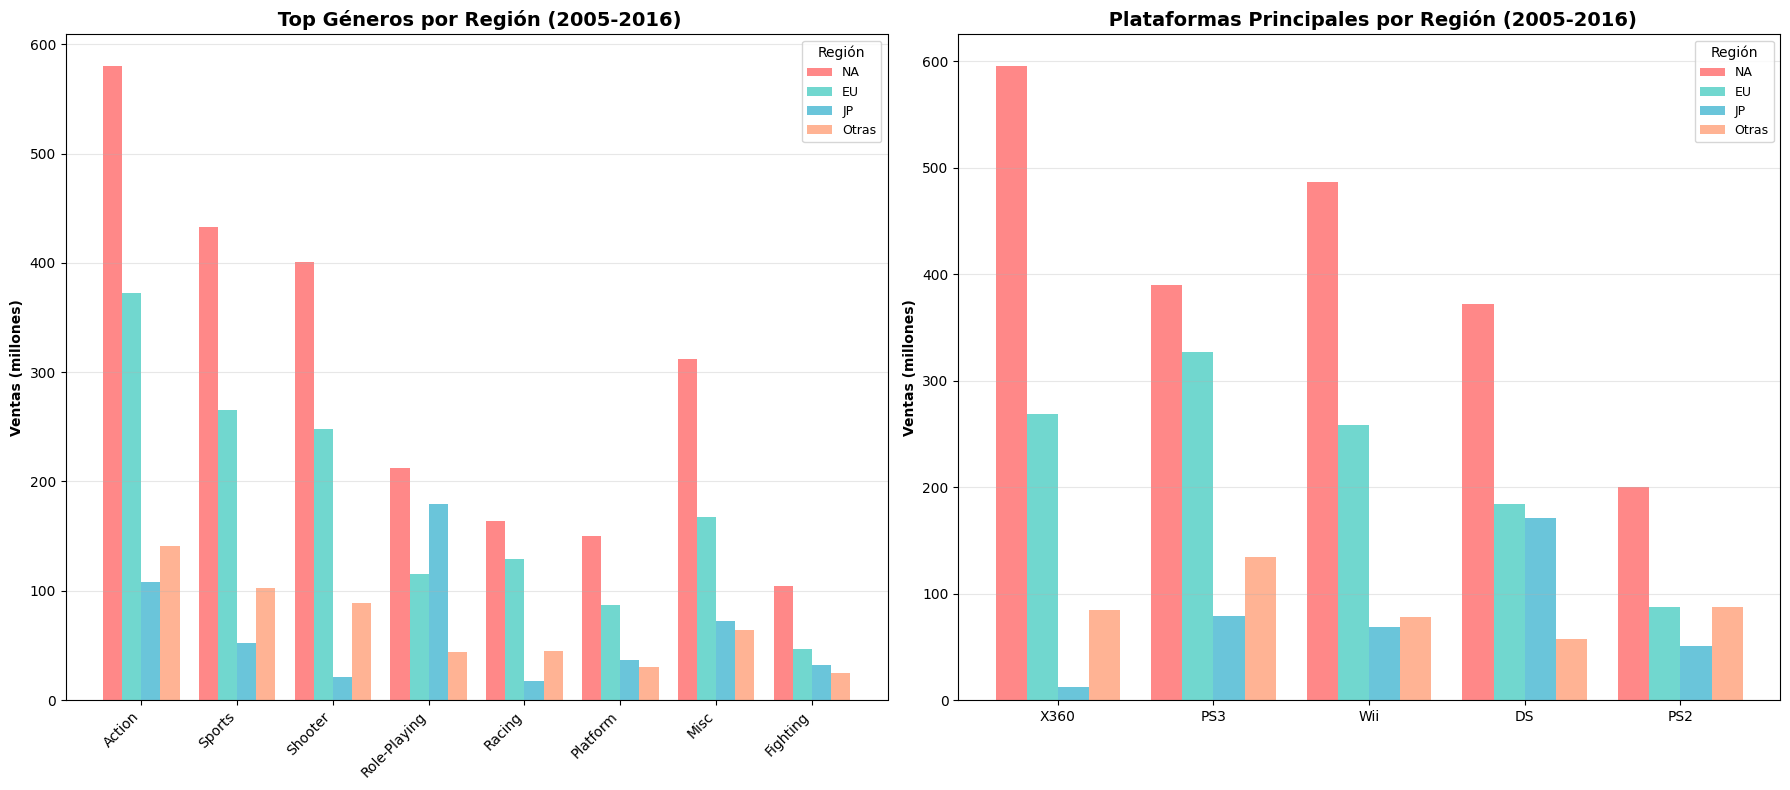

In [ ]:
# VISUALIZATION: Comparative charts by region (2005-2016) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Colors by region
colores_regiones = {
    'na_sales': '#FF6B6B',      # Red for NA
    'eu_sales': '#4ECDC4',      # Turquoise for EU  
    'jp_sales': '#45B7D1',      # Blue for JP
    'other_sales': '#FFA07A'    # Salmon for Others
}

# 1. GENRES BY REGION - All regions in one chart
principales_generos = ['Action', 'Sports', 'Shooter', 'Role-Playing', 'Racing', 'Platform', 'Misc', 'Fighting']
regiones = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
nombres_regiones = ['NA', 'EU', 'JP', 'Otras']

x = range(len(principales_generos))
width = 0.2

for i, (region, nombre) in enumerate(zip(regiones, nombres_regiones)):
    valores = [generos_por_region_periodo.loc[genero, region] if genero in generos_por_region_periodo.index else 0 
               for genero in principales_generos]
    ax1.bar([xi + i*width for xi in x], valores, width, 
           label=nombre, color=list(colores_regiones.values())[i], alpha=0.8)

ax1.set_title(' Top Genres by Region (2005-2016)', fontweight='bold', fontsize=14)
ax1.set_xticks([xi + width*1.5 for xi in x])
ax1.set_xticklabels(principales_generos, rotation=45, ha='right')
ax1.set_ylabel('Sales (millions)', fontweight='bold')
ax1.legend(title='Region', title_fontsize=10, fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2. PLATFORMS BY REGION - All regions in one chart
principales_plataformas = ['X360', 'PS3', 'Wii', 'DS', 'PS2']

x2 = range(len(principales_plataformas))

for i, (region, nombre) in enumerate(zip(regiones, nombres_regiones)):
    valores = [plataformas_por_region_periodo.loc[plat, region] if plat in plataformas_por_region_periodo.index else 0 
               for plat in principales_plataformas]
    ax2.bar([xi + i*width for xi in x2], valores, width, 
           label=nombre, color=list(colores_regiones.values())[i], alpha=0.8)

ax2.set_title(' Main Platforms by Region (2005-2016)', fontweight='bold', fontsize=14)
ax2.set_xticks([xi + width*1.5 for xi in x2])
ax2.set_xticklabels(principales_plataformas)
ax2.set_ylabel('Sales (millions)', fontweight='bold')
ax2.legend(title='Region', title_fontsize=10, fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Adjust layout
plt.tight_layout()




**Final comments on charts**
1. Genre:
Action dominates in NA, EU and Other regions
Role-Playing is especially strong in Japan
Sports has consistent presence in all regions
2. Platforms:
X360: Leader in NA, competitive in EU, weak in JP
PS3: Balanced between NA/EU, present in JP
DS: Absolute dominant in JP, lower western penetration
Wii: Consistent performance in all regions

### ESRB rating by region

In [ ]:
# ANALYSIS OF ESRB RATING IMPACT BY REGION (2005-2016)
print(" IMPACT OF ESRB RATINGS ON SALES BY REGION (2005-2016):\n")

# Filter only data with defined rating for the period
df_periodo_rating = df_periodo[df_periodo["rating"] != "Not defined"].copy()

print(f" DATA WITH ESRB RATING:")
print(f"• Games with rating: {len(df_periodo_rating):,}")
print(f"• Games without rating: {len(df_periodo) - len(df_periodo_rating):,}")
print(f"• Coverage: {len(df_periodo_rating)/len(df_periodo)*100:.1f}%")

# Calculate sales by rating and region
rating_por_region = df_periodo_rating.groupby("rating")[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum()

print(f"\n SALES BY ESRB RATING:")
print("="*80)
print(f"{'Rating':<8} {'NA (M)':<10} {'EU (M)':<10} {'JP (M)':<10} {'Others (M)':<10} {'Total (M)'}")
print("="*80)

for rating in rating_por_region.index.sort_values():
    na = rating_por_region.loc[rating, "na_sales"]
    eu = rating_por_region.loc[rating, "eu_sales"] 
    jp = rating_por_region.loc[rating, "jp_sales"]
    otras = rating_por_region.loc[rating, "other_sales"]
    total = na + eu + jp + otras
    
    print(f"{rating:<8} {na:>8.1f}   {eu:>8.1f}   {jp:>8.1f}   {otras:>10.1f}   {total:>8.1f}")

print("="*80)

# Analysis of preferences by region
print(f"\n PREFERENCE ANALYSIS BY RATING:")
for region, columna in [("Norteamérica", "na_sales"), ("Europa", "eu_sales"), ("Japón", "jp_sales"), ("Otras", "other_sales")]:
    top_rating = rating_por_region[columna].idxmax()
    top_ventas = rating_por_region[columna].max()
    total_region = rating_por_region[columna].sum()
    porcentaje = (top_ventas / total_region) * 100
    
    print(f"• {region}: Dominant rating '{top_rating}' ({porcentaje:.1f}% of market)")

 IMPACTO DE CLASIFICACIONES ESRB EN VENTAS POR REGIÓN (2005-2016):

 DATOS CON CLASIFICACIÓN ESRB:
• Juegos con rating: 7,310
• Juegos sin rating: 3,962
• Cobertura: 64.9%

 VENTAS POR CLASIFICACIÓN ESRB:
Rating   NA (M)     EU (M)     JP (M)     Otras (M)  Total (M)
AO            1.3        0.6        0.0          0.1        2.0
E           873.1      508.7      147.3        176.8     1705.9
E10+        343.0      181.9       39.1         71.4      635.4
EC            1.5        0.1        0.0          0.1        1.8
M           607.3      414.1       46.2        146.2     1213.8
RP            0.0        0.0        0.0          0.0        0.0
T           479.1      258.2       91.3        115.4      943.9

 ANÁLISIS DE PREFERENCIAS POR CLASIFICACIÓN:
• Norteamérica: Rating dominante 'E' (37.9% del mercado)
• Europa: Rating dominante 'E' (37.3% del mercado)
• Japón: Rating dominante 'E' (45.5% del mercado)
• Otras: Rating dominante 'E' (34.7% del mercado)


### Correlation between critic and user scores with sales

In [ ]:
# 1. Prepare dataset for correlation analysis (2005-2016)
print(" DATA PREPARATION FOR CORRELATION ANALYSIS (2005-2016)\n")

# Use dataset already filtered by period 2005-2016 
# Filter only games with complete review data
df_reviews_periodo = df_periodo[
    (df_periodo["critic_score"].notna()) & 
    (df_periodo["user_score"].notna()) &
    (df_periodo["total_sales"] > 0)
].copy()

print(f" Dataset period 2005-2016: {len(df_periodo):,} games")
print(f" Dataset with complete reviews: {len(df_reviews_periodo):,} games")
print(f" Excluded games: {len(df_periodo) - len(df_reviews_periodo):,} ({((len(df_periodo) - len(df_reviews_periodo)) / len(df_periodo) * 100):.1f}%)")

# Information from filtered dataset
print(f"\n SUMMARY OF FILTERED DATASET (2005-2016):")
print(f"• Critic Score range: {df_reviews_periodo['critic_score'].min():.1f} - {df_reviews_periodo['critic_score'].max():.1f}")
print(f"• User Score range: {df_reviews_periodo['user_score'].min():.1f} - {df_reviews_periodo['user_score'].max():.1f}")
print(f"• Average total sales: {df_reviews_periodo['total_sales'].mean():.2f} million")
print(f"• Year period: {int(df_reviews_periodo['year_of_release'].min())} - {int(df_reviews_periodo['year_of_release'].max())}")

# Verify distribution by region
print(f"\n REGIONAL SALES DISTRIBUTION (2005-2016, with reviews):")
for region, columna in [("NA", "na_sales"), ("EU", "eu_sales"), ("JP", "jp_sales"), ("Otras", "other_sales")]:
    total_region = df_reviews_periodo[columna].sum()
    promedio = df_reviews_periodo[columna].mean()
    print(f"• {region}: {total_region:,.0f}M total, {promedio:.2f}M average")

 PREPARACIÓN DE DATOS PARA ANÁLISIS DE CORRELACIONES (2005-2016)

 Dataset período 2005-2016: 11,272 juegos
 Dataset con reseñas completas: 5,023 juegos
 Juegos excluidos: 6,249 (55.4%)

 RESUMEN DEL DATASET FILTRADO (2005-2016):
• Rango de Critic Score: 1.3 - 9.8
• Rango de User Score: 0.5 - 9.4
• Ventas totales promedio: 0.79 millones
• Período de años: 2005 - 2016

 DISTRIBUCIÓN DE VENTAS REGIONALES (2005-2016, con reseñas):
• NA: 1,969M total, 0.39M promedio
• EU: 1,232M total, 0.25M promedio
• JP: 311M total, 0.06M promedio
• Otras: 449M total, 0.09M promedio


In [ ]:
# Function to calculate correlation and interpret it
def calcular_correlacion(data, column_x, column_y):
    """Calculate Pearson correlation and p-value"""
    correlation, p_value = pearsonr(data[column_x], data[column_y])
    return correlation, p_value

def interpretar_correlacion(r):
    """Interpret the strength of the correlation"""
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "Strong"
    elif abs_r >= 0.3:
        return "Moderate"
    elif abs_r >= 0.1:
        return "Weak"
    else:
        return "Very weak"

print(" CORRELATION ANALYSIS REVIEWS vs SALES BY REGION (2005-2016)\n")

# Calculate correlations for each region
regions = [("North America", "na_sales"), ("Europe", "eu_sales"), ("Japan", "jp_sales"), ("Other", "other_sales")]

print("="*100)
print(f"{'Region':<12} {'Critic vs Sales':<20} {'p-value':<10} {'User vs Sales':<20} {'p-value':<10} {'Interpretation'}")
print("="*100)

correlations_summary = {}

for region_name, sales_col in regions:
    # Correlation Critic Score vs Sales
    corr_critic, p_critic = calcular_correlacion(df_reviews_period, 'critic_score', sales_col)
    
    # Correlation User Score vs Sales  
    corr_user, p_user = calcular_correlacion(df_reviews_period, 'user_score', sales_col)
    
    # Interpret
    interp_critic = interpretar_correlacion(corr_critic)
    interp_user = interpretar_correlacion(corr_user)
    
    # Store for summary
    correlations_summary[region_name] = {
        'critic_corr': corr_critic,
        'user_corr': corr_user,
        'critic_p': p_critic,
        'user_p': p_user
    }
    
    print(f"{region_name:<12} {corr_critic:>8.3f} ({interp_critic:<8}) {p_critic:>8.3f}   {corr_user:>8.3f} ({interp_user:<8}) {p_user:>8.3f}   {'Critic>' if abs(corr_critic) > abs(corr_user) else 'User>' if abs(corr_user) > abs(corr_critic) else 'Similar'}")

print("="*100)

 ANÁLISIS DE CORRELACIONES RESEÑAS vs VENTAS POR REGIÓN (2005-2016)

Región       Critic vs Ventas     p-value    User vs Ventas       p-value    Interpretación
Norteamérica    0.216 (Débil   )    0.000      0.072 (Muy débil)    0.000   Critic>
Europa          0.215 (Débil   )    0.000      0.053 (Muy débil)    0.000   Critic>
Japón           0.125 (Débil   )    0.000      0.123 (Débil   )    0.000   Critic>
Otras           0.231 (Débil   )    0.000      0.072 (Muy débil)    0.000   Critic>


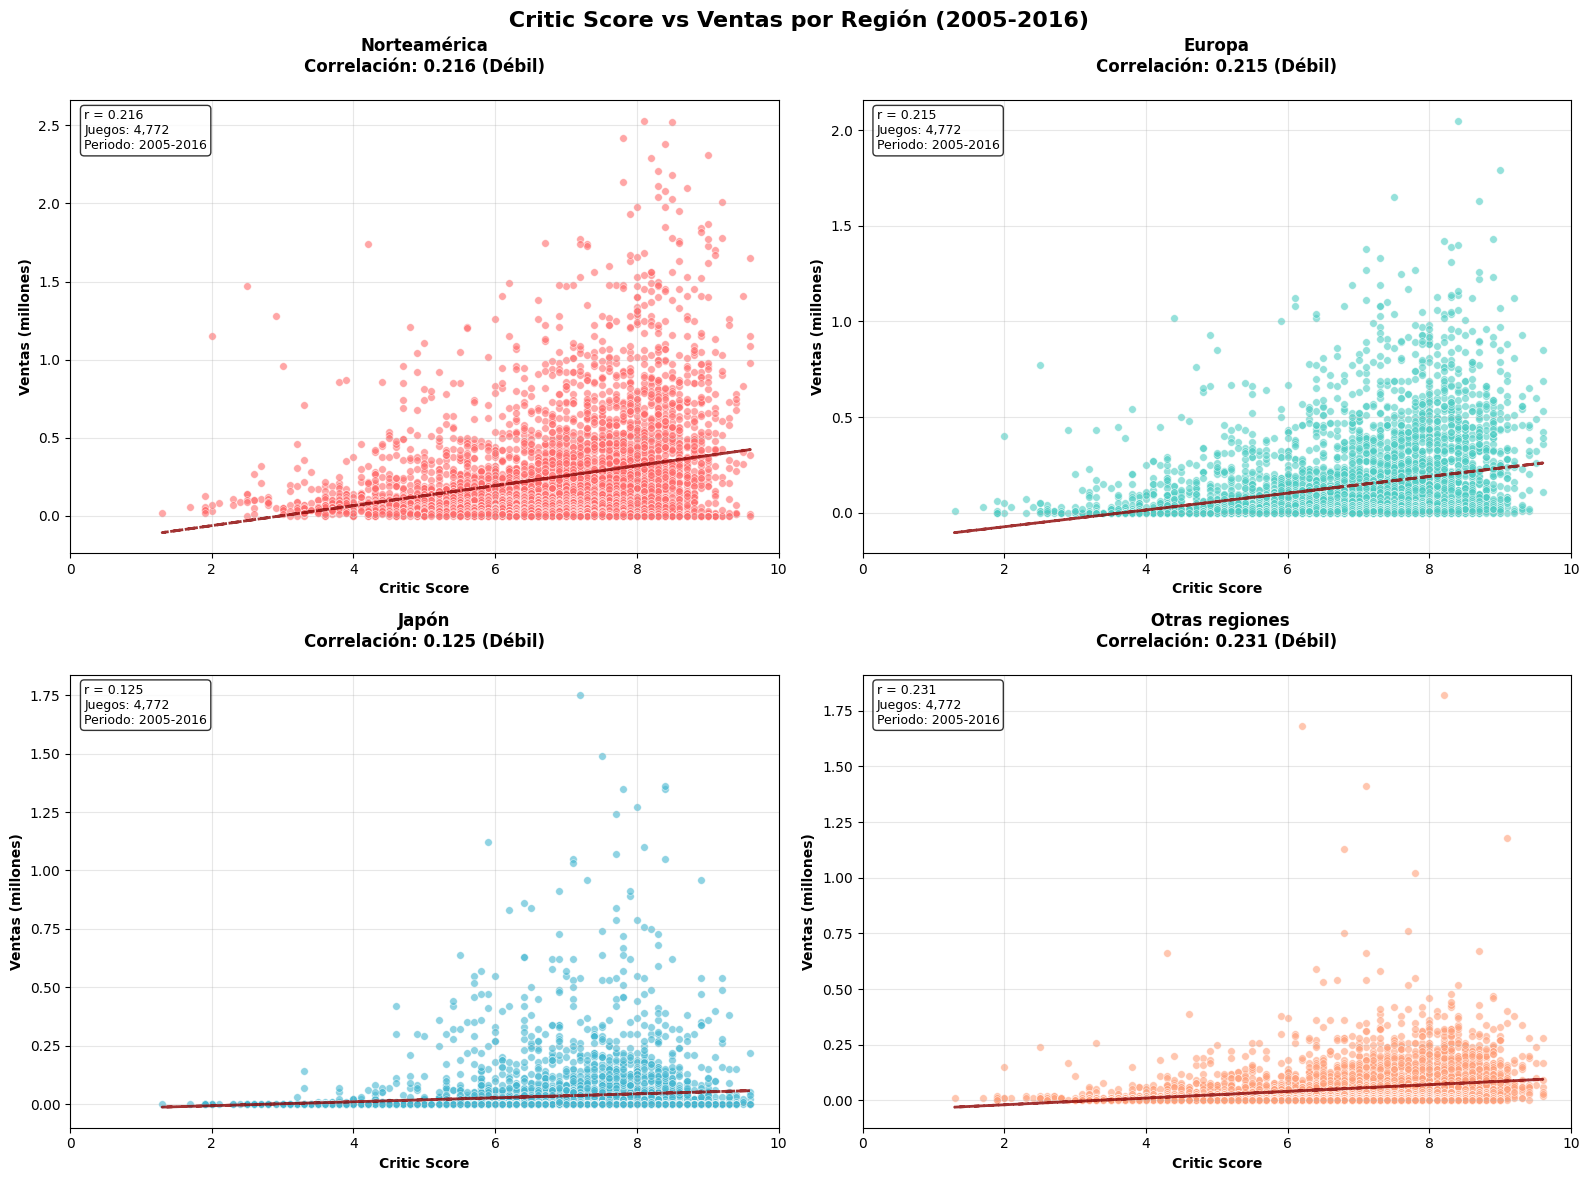

In [ ]:
# Create separate charts for Critic Score vs Sales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Color configuration
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
regions_info = [
    ("North America", "na_sales", colors[0]),
    ("Europe", "eu_sales", colors[1]), 
    ("Japan", "jp_sales", colors[2]),
    (" Other regions", "other_sales", colors[3])
]

# Filter extreme outliers (95th percentile)
df_viz = df_reviews_period[df_reviews_period['total_sales'] <= df_reviews_period['total_sales'].quantile(0.95)].copy()

for i, (region_name, sales_col, color) in enumerate(regions_info):
    ax = axes[i]
    
    # Data for the region
    x = df_viz['critic_score']
    y = df_viz[sales_col]
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.6, color=color, s=30, edgecolors='white', linewidth=0.5)
    
    # Trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), color='darkred', linewidth=2, linestyle='--', alpha=0.8)
    
    # Correlation
    corr = correlations_summary[region_name.split(' ')[1] if ' ' in region_name else region_name]['critic_corr']
    
    # Configure chart
    ax.set_xlabel('Critic Score', fontweight='bold')
    ax.set_ylabel('Sales (millions)', fontweight='bold')
    ax.set_title(f'{region_name}\nCorrelation: {corr:.3f} ({interpretar_correlacion(corr)})', 
                fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 10)
    
    # Add statistics in box
    textstr = f'r = {corr:.3f}\nGames: {len(df_viz):,}\nPeriod: 2005-2016'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

plt.suptitle(' Critic Score vs Sales by Region (2005-2016)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

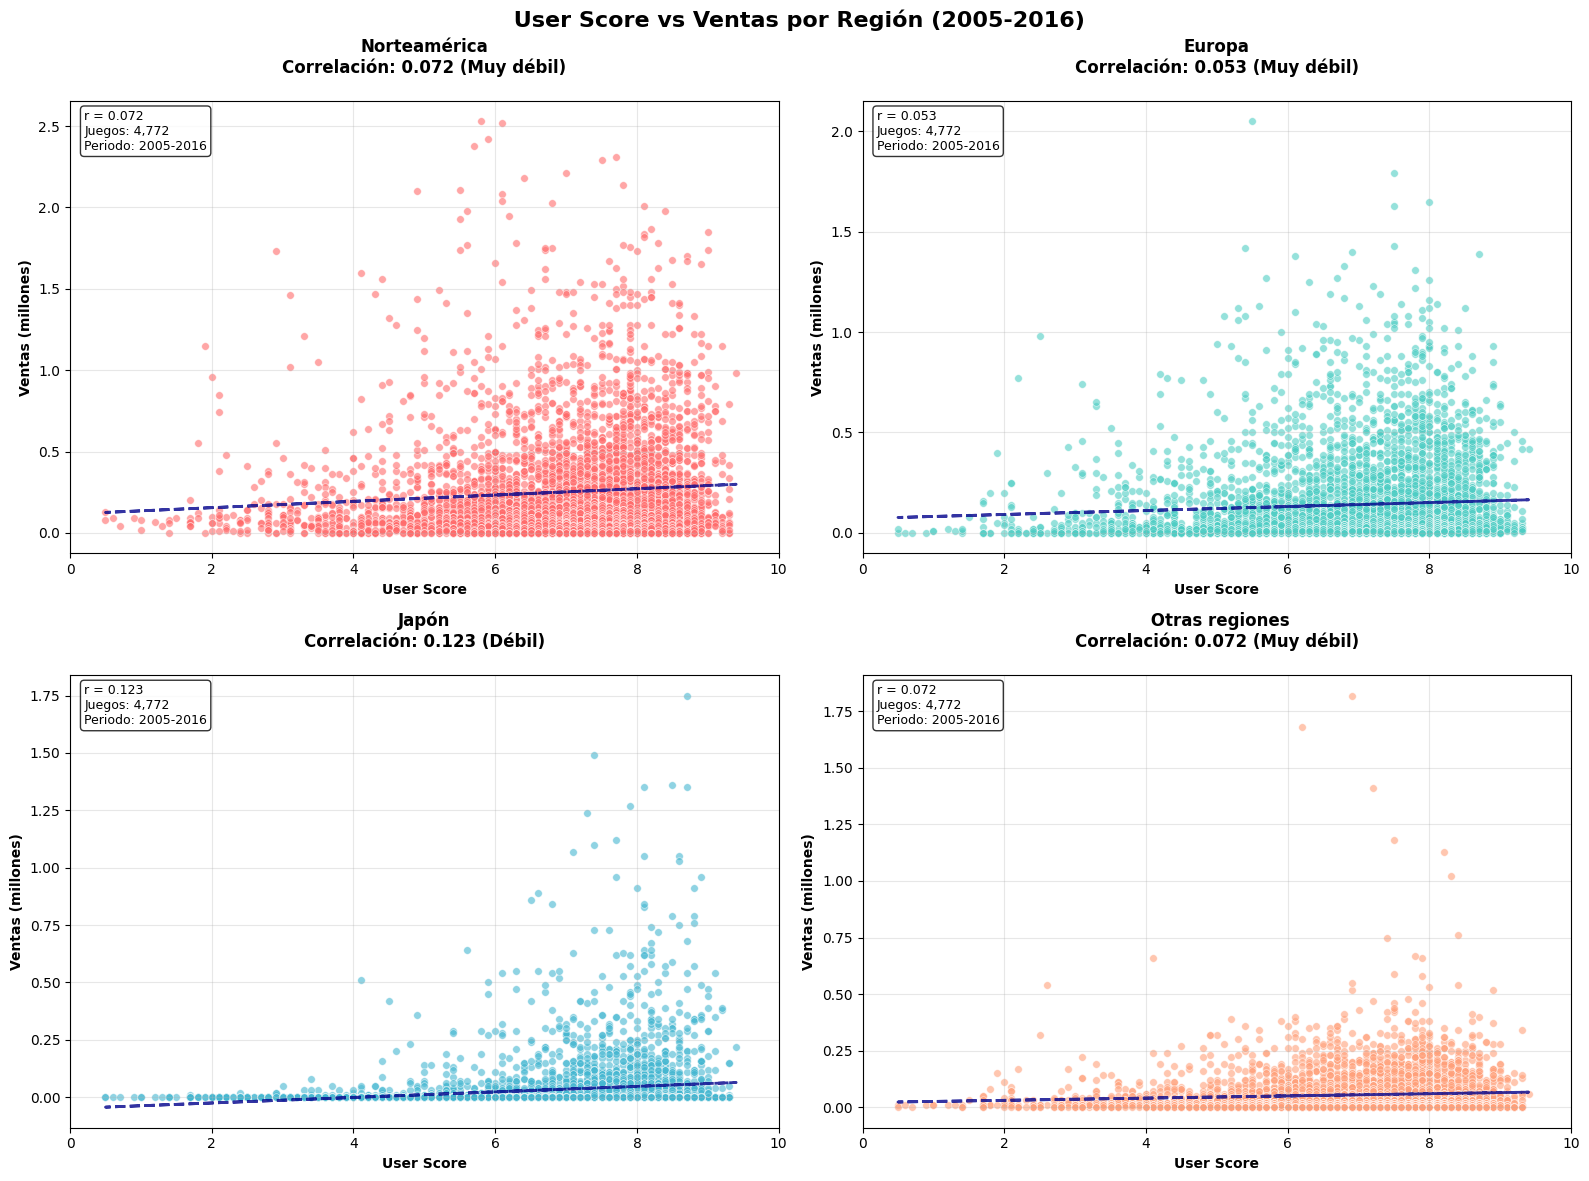

In [ ]:
# 3B. Visualization: User Score vs Sales by Region (2005-2016)

# Create separate charts for User Score vs Sales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (region_name, sales_col, color) in enumerate(regions_info):
    ax = axes[i]
    
    # Data for the region
    x = df_viz['user_score']
    y = df_viz[sales_col]
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.6, color=color, s=30, edgecolors='white', linewidth=0.5)
    
    # Trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), color='darkblue', linewidth=2, linestyle='--', alpha=0.8)
    
    # Correlation
    corr = correlations_summary[region_name.split(' ')[1] if ' ' in region_name else region_name]['user_corr']
    
    # Configure chart
    ax.set_xlabel('User Score', fontweight='bold')
    ax.set_ylabel('Sales (millions)', fontweight='bold')
    ax.set_title(f'{region_name}\nCorrelation: {corr:.3f} ({interpretar_correlacion(corr)})', 
                fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 10)
    
    # Add statistics in box
    textstr = f'r = {corr:.3f}\nGames: {len(df_viz):,}\nPeriod: 2005-2016'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

plt.suptitle(' User Score vs Sales by Region (2005-2016)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

**Conclusion on correlation between critic and user scores with sales by region**
1. The influence of reviews exists, but it is weak in general. The highest correlation was for Critic Score in "Other regions" (r = 0.231). No correlation exceeded the "Weak" category (r < 0.3).
2. User Score presents even lower correlations, in the "Very weak" range in most regions.
3. Professional reviews (Critic Score) show a slightly higher impact than user reviews (User Score) in all regions, except in Japan where both scores are almost at the same level.
4. North America and Europe show quite similar patterns: Sales tend to rise slightly with better reviews, but there are many high-scoring titles without large sales and vice versa.
5. Japan shows different behaviors: Sales are generally lower. There is more dispersion in titles with good reviews.
6. It is demonstrated again that the correlation between the given scores and sales is weak, so there must be other factors involved for a game to guarantee success, but the score is not one of them.

**General conclusion on regions**
1. Although the data includes 4 regions, when analyzing preferences by genre, platform, and rating, we can see that North America, Europe, and other regions follow a very similar pattern.
2. Japan is a small region, but differences can be seen in the genres they prefer and the platforms, even leaning more towards portable ones.
3. A good marketing strategy must take psychographic and demographic factors into account. By gathering data by region, this analysis or consideration becomes simpler, as regions differ in terms of lifestyle, income, and preferences. Analyzing differences and similarities by region provides valuable information for this.

## Hypotheses

**General information**
We will work on the following two hypotheses:

— The average user ratings for Xbox One and PC platforms are the same.

— The average user ratings for Action and Sports genres are different.


### Construcción y comprobación de hipótesis 

In [ ]:
from scipy import stats as st
# --- HYPOTHESIS 1: Xbox One vs PC ---

# H₀: The mean of user ratings on Xbox One and PC is equal.
# H₁: The mean of user ratings on Xbox One and PC is different.

# Filter necessary data and remove nulls
xbox_pc_scores = df_games[df_games["platform"].isin(["XOne", "PC"])][["platform", "user_score"]].dropna()

# Split into two groups
xbox_scores = xbox_pc_scores[xbox_pc_scores["platform"] == "XOne"]["user_score"]
pc_scores = xbox_pc_scores[xbox_pc_scores["platform"] == "PC"]["user_score"]

# Apply Student's t-test for independent samples
xbox_pc_test = stats.ttest_ind(xbox_scores, pc_scores, equal_var=False)

# Print results
print("HYPOTHESIS 1: Xbox One vs PC")
print("t-statistic:", xbox_pc_test.statistic)
print("p-value:", xbox_pc_test.pvalue)

# Interpretation
alpha = 0.05
if xbox_pc_test.pvalue < alpha:
    print("Result: We reject H₀ — there is a significant difference between the ratings.")
else:
    print("Result: Cannot reject H₀ — there is no significant difference.")





HIPÓTESIS 1: Xbox One vs PC
Estadístico t: -4.653422798410771
Valor p: 4.935072360183574e-06
Resultado: Rechazamos H₀ — hay diferencia significativa entre las calificaciones.


**Explanation about the hypothesis**
1. We start from user scores to find out if there is a relationship with two platforms, we want to know if users rate them the same way, this gives us a greater perspective regarding the user's role with respect to different platforms.
2. Our null hypothesis is based on there being a difference, while the alternative claims they are not different.
3. We use the t-student test, since they are independent samples and we do not assume equal variances, since platforms represent different groups.
4. Chosen alpha threshold: 0.05 (5%) - commonly accepted value for a balance between false positives and false negatives.
5. The result was that there is a significant difference between the ratings, which tells us that being different platforms, the audience is different and they have different opinions.

In [ ]:
# --- HYPOTHESIS 2: Action vs Sports ---

# H₀: The means of ratings for Action and Sports genres are equal.
# H₁: The means of ratings for Action and Sports genres are different.

# Filter necessary data and remove nulls
action_sports_scores = df_games[df_games["genre"].isin(["Action", "Sports"])][["genre", "user_score"]].dropna()

# Split into two groups
action_scores = action_sports_scores[action_sports_scores["genre"] == "Action"]["user_score"]
sports_scores = action_sports_scores[action_sports_scores["genre"] == "Sports"]["user_score"]

# Apply Student's t-test for independent samples
action_sports_test = stats.ttest_ind(action_scores, sports_scores, equal_var=False)

# Print results
print("\nHYPOTHESIS 2: Action vs Sports")
print("t-statistic:", action_sports_test.statistic)
print("p-value:", action_sports_test.pvalue)

# Interpretation
if action_sports_test.pvalue < alpha:
    print("Result: We reject H₀ — there is a significant difference between the ratings.")
else:
    print("Result: Cannot reject H₀ — there is no significant difference.")



HIPÓTESIS 2: Acción vs Deportes
Estadístico t: 1.57746791633354
Valor p: 0.11483818791498286
Resultado: No se puede rechazar H₀ — no hay diferencia significativa.


**Explanation about the hypothesis**
1. For this hypothesis we continue starting from user ratings, but this time for genres. We want to know if action and sports genres are rated the same.
2. Our null hypothesis states that the average user ratings for Action and Sports genres are equal, while our alternative hypothesis states that they are different.
3. We again use the t-student test, without assuming equal variances, alpha value of 0.05.
4. Since p > 0.05, the null hypothesis is not rejected. This indicates that there is not enough statistical evidence to claim that the average ratings between Action and Sports are different.

### Box plots for hypotheses

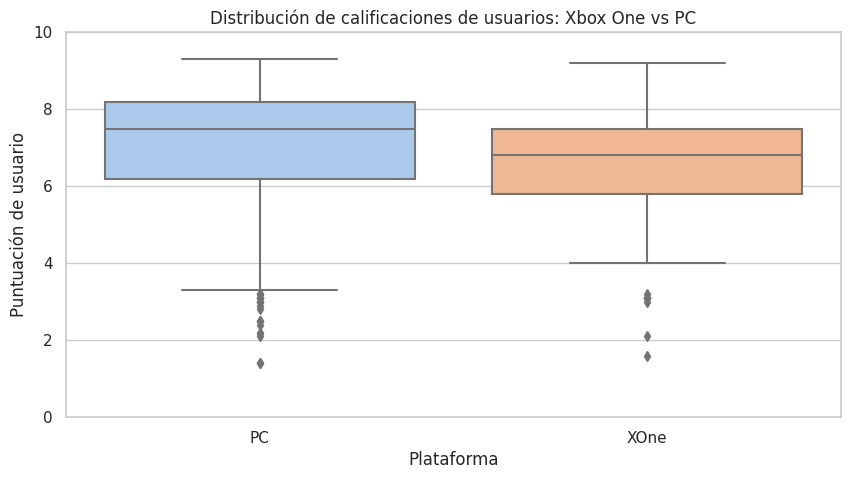

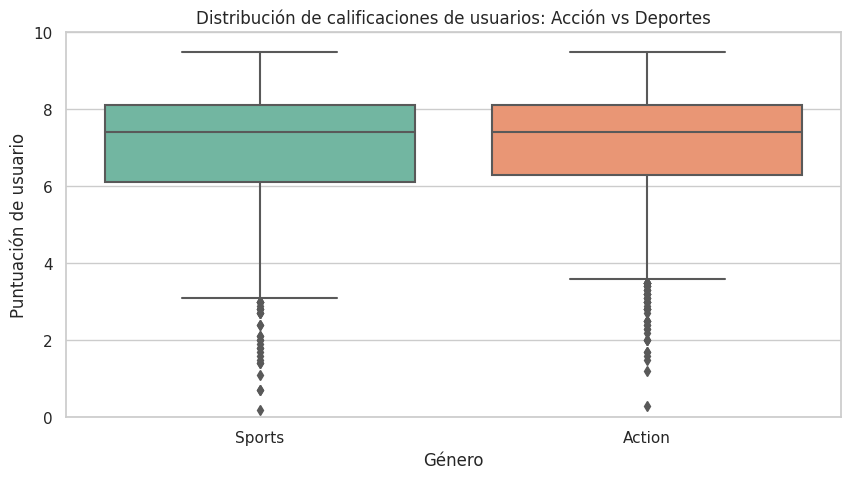

In [ ]:
# Visual style
sns.set(style="whitegrid")

# --- Chart for Hypothesis 1: Xbox One vs PC ---
plt.figure(figsize=(10, 5))
sns.boxplot(x="platform", y="user_score", data=xbox_pc_scores, palette="pastel")
plt.title("Distribution of user ratings: Xbox One vs PC")
plt.xlabel("Platform")
plt.ylabel("User score")
plt.ylim(0, 10)
plt.show()

# --- Chart for Hypothesis 2: Action vs Sports ---
plt.figure(figsize=(10, 5))
sns.boxplot(x="genre", y="user_score", data=action_sports_scores, palette="Set2")
plt.title("Distribution of user ratings: Action vs Sports")
plt.xlabel("Genre")
plt.ylabel("User score")
plt.ylim(0, 10)
plt.show()


**Comment on box plots**
1. The box plot shows that user ratings for Xbox One tend to be higher than for PC.
This visually supports the statistical result: there is a significant difference between platforms.
2. Although the box plot shows some difference in the median, the interquartile ranges (IQR) overlap considerably. This coincides with the statistical analysis: there is not enough evidence to claim that the means are different between genres.

## General conclusion

1. **Overall sales:** The release of video games in 1980 represents a revolutionary milestone in entertainment, however, sales begin to rise until 2000 to levels much higher than at the start. This represents an increase in game options, new genres, consoles and strategies to reach customers.
2. **Platforms:** In 2000 different companies entered the video game market (Sony and Microsoft) competing with the already established and successful Nintendo. More options in the market means more spending, but also more need for innovation. We can observe that the lifespan of platforms becomes shorter, evidencing those that were successful, such as the PS2 and Wii. With each new launch, a new success is expected, however, many platforms went unnoticed or small next to those that achieved sales at very high levels.
3. **Genres:** Although at the beginning the supply of video games and genres was limited, as it increased, sales rose a lot, but also the difference between platform preferences. That's where we can realize that different factors affect sales, as it will depend on the quality of the game with respect to the platform, and even aspects such as price and popularity can affect the result of each video game. The most successful genres are action, sports and shooter.
4. **Critic and user scores:** Several games in the market do not apply to have this score, however, it is not a decisive factor for the success of a video game, so it doesn't matter if it has been tested or not, there are more important factors to consider to achieve good sales.
5. **Nintendo:** The company with the most time and experience, is the one that has launched the most consoles and represents great success in the community, however, its sales are not so homogeneous, as its sales tend to have super successes but also very large failures, even in entire platforms (WiiU). The genre with the highest sales is sports and its best console has been the Wii. When analyzing other non-quantitative factors, innovation and customer loyalty can be highlighted. It is also the leader in portable platforms. It is Japan's favorite.
6. **Sony (PlayStation):** Entered in the early 2000s, world leader in video game sales, no one has matched its figures, especially with the PS2. It continues to innovate and maintain itself in the market, the successors of the PS2 have shown good sales, however, in the portable area it has not had the same success. It shows us that as a company it has known how to reach customers, its game offerings are very broad and the most successful genre they have in greater quantity: action. Its sales are homogeneous, which represents greater stability. It is the global favorite.
7. **Microsoft:** The third leading company. Its entry also begins in the 2000s, enters with strength, however, it does not manage to reach its competitors. Its best genre is Shooter and it is one of the main ones globally. Its sales also represent stability, helped by the genre offerings it provides and staying on par with the competition, as it always launches successors to not let its offering die. Globally it is 2nd, below SONY.
8. **Regions:** The region with the highest video game sales is North America, making it the world leader and exponent. As regions, almost all have similar levels of preferences in terms of genres and platforms, only Japan shows different behavior, as it prefers Nintendo consoles and genres like Role-Playing over action.
9. **ESRB Rating:** Despite the fact that the most successful genres are Action and Shooter, which could be considered T or M, globally the best-selling is E (EVERYONE), this may be due to the fact that many genres fall into that classification and the weighted sales end up being E.
10. **2017 Strategy** By the end of 2016 there are still many platforms in the market, however from Nintendo they are in decline. It could be said that based on the data, the most successful games would be Action and Shooter, for Sony and Microsoft consoles, however, if an innovation appears from Nintendo, its exclusive games represent a high probability of success. It is not necessary to use the critic or user score, but rather better promote the game's story, its graphics, and know how to direct it to the right audience.
11. *Personal opinion* It was a very interesting project, I really like video games, so knowing this information impressed me a lot and I understood it quite well. I learned a lot about statistics and the accurate data they provide.